# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'assets/processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='assets/processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param image_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # resize to image_size
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()])

    # define dataset using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)

    # create and return DataLoaders
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

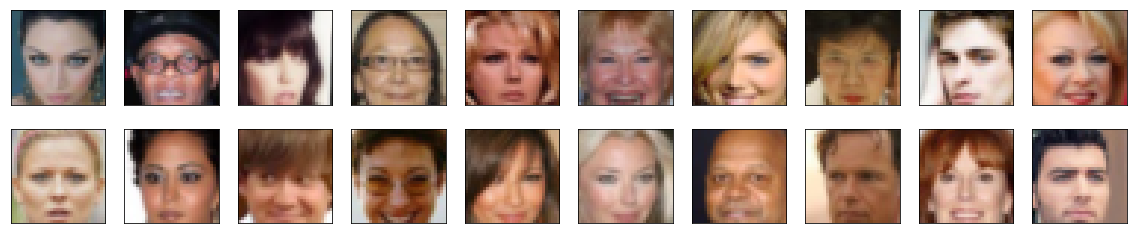

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9608)
Max:  tensor(0.6000)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.conv_dim = conv_dim

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm 
        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [10]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function  
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'Linear' in classname:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)  

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
# using mean squared error.

def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    return torch.mean((D_out-1)**2)

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    return torch.mean(D_out**2)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            

            # 1. Train the discriminator on real and fake images
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================
            d_optimizer.zero_grad()
              
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
                     
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 1000

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/ 1000] | d_loss: 1.0516 | g_loss: 0.7857
Epoch [    1/ 1000] | d_loss: 0.0965 | g_loss: 1.6701
Epoch [    1/ 1000] | d_loss: 0.0581 | g_loss: 1.4356
Epoch [    1/ 1000] | d_loss: 0.0545 | g_loss: 1.0037
Epoch [    1/ 1000] | d_loss: 0.0962 | g_loss: 1.2744
Epoch [    1/ 1000] | d_loss: 0.4737 | g_loss: 0.2635
Epoch [    1/ 1000] | d_loss: 0.2743 | g_loss: 0.3480
Epoch [    1/ 1000] | d_loss: 0.0962 | g_loss: 0.9342
Epoch [    1/ 1000] | d_loss: 0.1193 | g_loss: 1.0149
Epoch [    1/ 1000] | d_loss: 0.1875 | g_loss: 0.8461
Epoch [    1/ 1000] | d_loss: 0.1850 | g_loss: 0.8475
Epoch [    1/ 1000] | d_loss: 0.3384 | g_loss: 1.2481
Epoch [    1/ 1000] | d_loss: 0.3441 | g_loss: 1.3960
Epoch [    1/ 1000] | d_loss: 0.2437 | g_loss: 0.6091
Epoch [    1/ 1000] | d_loss: 0.3717 | g_loss: 0.1843
Epoch [    2/ 1000] | d_loss: 0.2025 | g_loss: 0.6487
Epoch [    2/ 1000] | d_loss: 0.8476 | g_loss: 0.8257
Epoch [    2/ 1000] | d_loss: 0.2854 | g_loss: 0.6385
Epoch [    2/ 1000] | d_loss

Epoch [   11/ 1000] | d_loss: 0.3196 | g_loss: 0.4632
Epoch [   11/ 1000] | d_loss: 0.2563 | g_loss: 0.7519
Epoch [   11/ 1000] | d_loss: 0.3750 | g_loss: 0.4055
Epoch [   11/ 1000] | d_loss: 0.4242 | g_loss: 0.1070
Epoch [   11/ 1000] | d_loss: 0.2959 | g_loss: 0.4537
Epoch [   11/ 1000] | d_loss: 0.3406 | g_loss: 0.6021
Epoch [   11/ 1000] | d_loss: 0.2955 | g_loss: 0.5541
Epoch [   11/ 1000] | d_loss: 0.2995 | g_loss: 0.7108
Epoch [   11/ 1000] | d_loss: 0.3241 | g_loss: 0.4747
Epoch [   11/ 1000] | d_loss: 0.3503 | g_loss: 1.0108
Epoch [   11/ 1000] | d_loss: 0.3496 | g_loss: 0.5908
Epoch [   11/ 1000] | d_loss: 0.6258 | g_loss: 0.2948
Epoch [   11/ 1000] | d_loss: 0.3634 | g_loss: 0.5798
Epoch [   12/ 1000] | d_loss: 0.2878 | g_loss: 0.5945
Epoch [   12/ 1000] | d_loss: 0.3435 | g_loss: 0.4138
Epoch [   12/ 1000] | d_loss: 0.3090 | g_loss: 0.4067
Epoch [   12/ 1000] | d_loss: 0.3178 | g_loss: 0.5367
Epoch [   12/ 1000] | d_loss: 0.3242 | g_loss: 0.5790
Epoch [   12/ 1000] | d_loss

Epoch [   21/ 1000] | d_loss: 0.2210 | g_loss: 0.4672
Epoch [   21/ 1000] | d_loss: 0.3190 | g_loss: 0.7829
Epoch [   21/ 1000] | d_loss: 0.2299 | g_loss: 0.3691
Epoch [   21/ 1000] | d_loss: 0.2340 | g_loss: 0.4365
Epoch [   21/ 1000] | d_loss: 0.2248 | g_loss: 0.5883
Epoch [   21/ 1000] | d_loss: 0.2554 | g_loss: 0.5645
Epoch [   21/ 1000] | d_loss: 0.2099 | g_loss: 0.8101
Epoch [   21/ 1000] | d_loss: 0.3120 | g_loss: 0.3189
Epoch [   21/ 1000] | d_loss: 0.1822 | g_loss: 0.8011
Epoch [   21/ 1000] | d_loss: 0.1935 | g_loss: 0.7630
Epoch [   21/ 1000] | d_loss: 0.1896 | g_loss: 0.9599
Epoch [   22/ 1000] | d_loss: 0.2011 | g_loss: 1.1335
Epoch [   22/ 1000] | d_loss: 0.2711 | g_loss: 0.8573
Epoch [   22/ 1000] | d_loss: 0.2573 | g_loss: 0.5907
Epoch [   22/ 1000] | d_loss: 0.1449 | g_loss: 0.6562
Epoch [   22/ 1000] | d_loss: 0.1480 | g_loss: 0.5903
Epoch [   22/ 1000] | d_loss: 0.1686 | g_loss: 0.4057
Epoch [   22/ 1000] | d_loss: 0.3948 | g_loss: 0.5570
Epoch [   22/ 1000] | d_loss

Epoch [   31/ 1000] | d_loss: 0.2992 | g_loss: 0.6851
Epoch [   31/ 1000] | d_loss: 0.1910 | g_loss: 0.7012
Epoch [   31/ 1000] | d_loss: 0.2129 | g_loss: 0.5748
Epoch [   31/ 1000] | d_loss: 0.1775 | g_loss: 0.7298
Epoch [   31/ 1000] | d_loss: 0.1871 | g_loss: 0.3861
Epoch [   31/ 1000] | d_loss: 0.1129 | g_loss: 0.7396
Epoch [   31/ 1000] | d_loss: 0.2437 | g_loss: 0.4907
Epoch [   31/ 1000] | d_loss: 0.1796 | g_loss: 1.0005
Epoch [   31/ 1000] | d_loss: 0.1546 | g_loss: 0.6014
Epoch [   32/ 1000] | d_loss: 0.1599 | g_loss: 0.6691
Epoch [   32/ 1000] | d_loss: 0.2144 | g_loss: 0.7329
Epoch [   32/ 1000] | d_loss: 0.2198 | g_loss: 0.4397
Epoch [   32/ 1000] | d_loss: 0.3144 | g_loss: 0.8795
Epoch [   32/ 1000] | d_loss: 0.1914 | g_loss: 0.6773
Epoch [   32/ 1000] | d_loss: 0.5429 | g_loss: 0.2445
Epoch [   32/ 1000] | d_loss: 0.4072 | g_loss: 0.2425
Epoch [   32/ 1000] | d_loss: 0.1785 | g_loss: 0.9378
Epoch [   32/ 1000] | d_loss: 0.1425 | g_loss: 0.4561
Epoch [   32/ 1000] | d_loss

Epoch [   41/ 1000] | d_loss: 0.1679 | g_loss: 0.9176
Epoch [   41/ 1000] | d_loss: 0.1793 | g_loss: 0.7297
Epoch [   41/ 1000] | d_loss: 0.1797 | g_loss: 0.7972
Epoch [   41/ 1000] | d_loss: 0.1676 | g_loss: 1.0725
Epoch [   41/ 1000] | d_loss: 0.1547 | g_loss: 1.3864
Epoch [   41/ 1000] | d_loss: 0.8122 | g_loss: 0.1284
Epoch [   41/ 1000] | d_loss: 0.1248 | g_loss: 0.7394
Epoch [   42/ 1000] | d_loss: 0.2228 | g_loss: 1.0655
Epoch [   42/ 1000] | d_loss: 0.1184 | g_loss: 1.0646
Epoch [   42/ 1000] | d_loss: 0.1455 | g_loss: 0.3653
Epoch [   42/ 1000] | d_loss: 0.0762 | g_loss: 0.6490
Epoch [   42/ 1000] | d_loss: 0.1323 | g_loss: 1.1318
Epoch [   42/ 1000] | d_loss: 0.1508 | g_loss: 0.6742
Epoch [   42/ 1000] | d_loss: 0.1029 | g_loss: 1.1688
Epoch [   42/ 1000] | d_loss: 0.1007 | g_loss: 1.1779
Epoch [   42/ 1000] | d_loss: 0.1858 | g_loss: 0.5482
Epoch [   42/ 1000] | d_loss: 0.0860 | g_loss: 0.7248
Epoch [   42/ 1000] | d_loss: 0.3445 | g_loss: 1.4671
Epoch [   42/ 1000] | d_loss

Epoch [   51/ 1000] | d_loss: 0.1477 | g_loss: 1.1981
Epoch [   51/ 1000] | d_loss: 0.1954 | g_loss: 1.1218
Epoch [   51/ 1000] | d_loss: 0.1630 | g_loss: 1.2295
Epoch [   51/ 1000] | d_loss: 0.1642 | g_loss: 1.2031
Epoch [   51/ 1000] | d_loss: 0.0841 | g_loss: 0.8013
Epoch [   52/ 1000] | d_loss: 0.0941 | g_loss: 0.7887
Epoch [   52/ 1000] | d_loss: 0.1187 | g_loss: 1.0228
Epoch [   52/ 1000] | d_loss: 0.1575 | g_loss: 1.0442
Epoch [   52/ 1000] | d_loss: 0.5647 | g_loss: 0.3108
Epoch [   52/ 1000] | d_loss: 0.2587 | g_loss: 0.6739
Epoch [   52/ 1000] | d_loss: 0.1598 | g_loss: 0.6194
Epoch [   52/ 1000] | d_loss: 0.0716 | g_loss: 0.7780
Epoch [   52/ 1000] | d_loss: 0.0862 | g_loss: 0.5688
Epoch [   52/ 1000] | d_loss: 0.1263 | g_loss: 0.7832
Epoch [   52/ 1000] | d_loss: 0.1220 | g_loss: 0.7428
Epoch [   52/ 1000] | d_loss: 0.2024 | g_loss: 0.9616
Epoch [   52/ 1000] | d_loss: 0.1420 | g_loss: 1.0108
Epoch [   52/ 1000] | d_loss: 0.2571 | g_loss: 0.7969
Epoch [   52/ 1000] | d_loss

Epoch [   61/ 1000] | d_loss: 0.1860 | g_loss: 0.9169
Epoch [   61/ 1000] | d_loss: 0.1835 | g_loss: 0.5694
Epoch [   61/ 1000] | d_loss: 0.1979 | g_loss: 0.5712
Epoch [   62/ 1000] | d_loss: 0.1019 | g_loss: 0.6863
Epoch [   62/ 1000] | d_loss: 0.4761 | g_loss: 1.6930
Epoch [   62/ 1000] | d_loss: 0.1253 | g_loss: 0.4839
Epoch [   62/ 1000] | d_loss: 0.0898 | g_loss: 0.7998
Epoch [   62/ 1000] | d_loss: 0.0995 | g_loss: 1.1126
Epoch [   62/ 1000] | d_loss: 0.0747 | g_loss: 0.6961
Epoch [   62/ 1000] | d_loss: 0.1260 | g_loss: 0.7005
Epoch [   62/ 1000] | d_loss: 0.1621 | g_loss: 1.1042
Epoch [   62/ 1000] | d_loss: 0.0986 | g_loss: 1.3702
Epoch [   62/ 1000] | d_loss: 0.1155 | g_loss: 0.6410
Epoch [   62/ 1000] | d_loss: 0.1222 | g_loss: 0.5995
Epoch [   62/ 1000] | d_loss: 0.0572 | g_loss: 0.8564
Epoch [   62/ 1000] | d_loss: 0.0923 | g_loss: 0.9324
Epoch [   62/ 1000] | d_loss: 0.0661 | g_loss: 0.9685
Epoch [   62/ 1000] | d_loss: 0.1527 | g_loss: 0.6286
Epoch [   63/ 1000] | d_loss

Epoch [   71/ 1000] | d_loss: 0.4737 | g_loss: 0.4008
Epoch [   72/ 1000] | d_loss: 0.4282 | g_loss: 0.3584
Epoch [   72/ 1000] | d_loss: 0.2118 | g_loss: 0.5994
Epoch [   72/ 1000] | d_loss: 0.0952 | g_loss: 0.7109
Epoch [   72/ 1000] | d_loss: 0.1451 | g_loss: 0.8217
Epoch [   72/ 1000] | d_loss: 0.0881 | g_loss: 0.9947
Epoch [   72/ 1000] | d_loss: 0.0855 | g_loss: 0.9683
Epoch [   72/ 1000] | d_loss: 0.1488 | g_loss: 0.6956
Epoch [   72/ 1000] | d_loss: 0.0764 | g_loss: 0.8803
Epoch [   72/ 1000] | d_loss: 0.1178 | g_loss: 0.7783
Epoch [   72/ 1000] | d_loss: 0.1626 | g_loss: 1.1324
Epoch [   72/ 1000] | d_loss: 0.1281 | g_loss: 0.7362
Epoch [   72/ 1000] | d_loss: 0.0843 | g_loss: 1.1540
Epoch [   72/ 1000] | d_loss: 0.0733 | g_loss: 1.1309
Epoch [   72/ 1000] | d_loss: 1.9845 | g_loss: 0.8332
Epoch [   72/ 1000] | d_loss: 0.4961 | g_loss: 0.3016
Epoch [   73/ 1000] | d_loss: 0.5170 | g_loss: 0.2650
Epoch [   73/ 1000] | d_loss: 0.4652 | g_loss: 0.3214
Epoch [   73/ 1000] | d_loss

Epoch [   82/ 1000] | d_loss: 0.0563 | g_loss: 0.7131
Epoch [   82/ 1000] | d_loss: 0.0627 | g_loss: 0.8089
Epoch [   82/ 1000] | d_loss: 0.0711 | g_loss: 0.7473
Epoch [   82/ 1000] | d_loss: 0.1564 | g_loss: 0.5643
Epoch [   82/ 1000] | d_loss: 0.4704 | g_loss: 0.2896
Epoch [   82/ 1000] | d_loss: 0.3110 | g_loss: 0.7400
Epoch [   82/ 1000] | d_loss: 0.1334 | g_loss: 1.0866
Epoch [   82/ 1000] | d_loss: 0.1017 | g_loss: 0.5094
Epoch [   82/ 1000] | d_loss: 0.0750 | g_loss: 1.1067
Epoch [   82/ 1000] | d_loss: 0.0858 | g_loss: 0.7522
Epoch [   82/ 1000] | d_loss: 0.0583 | g_loss: 0.7636
Epoch [   82/ 1000] | d_loss: 0.1130 | g_loss: 0.6420
Epoch [   82/ 1000] | d_loss: 0.0804 | g_loss: 0.8942
Epoch [   82/ 1000] | d_loss: 0.0621 | g_loss: 0.9439
Epoch [   83/ 1000] | d_loss: 0.0389 | g_loss: 1.1608
Epoch [   83/ 1000] | d_loss: 0.1267 | g_loss: 1.2147
Epoch [   83/ 1000] | d_loss: 0.3363 | g_loss: 0.6852
Epoch [   83/ 1000] | d_loss: 0.1384 | g_loss: 0.6178
Epoch [   83/ 1000] | d_loss

Epoch [   92/ 1000] | d_loss: 0.0631 | g_loss: 0.9959
Epoch [   92/ 1000] | d_loss: 0.0609 | g_loss: 0.7998
Epoch [   92/ 1000] | d_loss: 0.1055 | g_loss: 0.9752
Epoch [   92/ 1000] | d_loss: 0.1219 | g_loss: 0.6369
Epoch [   92/ 1000] | d_loss: 0.1555 | g_loss: 0.4869
Epoch [   92/ 1000] | d_loss: 0.0774 | g_loss: 1.0063
Epoch [   92/ 1000] | d_loss: 0.0746 | g_loss: 1.0963
Epoch [   92/ 1000] | d_loss: 0.0479 | g_loss: 0.9228
Epoch [   92/ 1000] | d_loss: 0.0365 | g_loss: 0.8130
Epoch [   92/ 1000] | d_loss: 0.0308 | g_loss: 0.9647
Epoch [   92/ 1000] | d_loss: 0.0727 | g_loss: 0.9842
Epoch [   92/ 1000] | d_loss: 0.0929 | g_loss: 0.6293
Epoch [   93/ 1000] | d_loss: 0.0588 | g_loss: 0.9420
Epoch [   93/ 1000] | d_loss: 0.0859 | g_loss: 0.6622
Epoch [   93/ 1000] | d_loss: 0.1202 | g_loss: 0.6084
Epoch [   93/ 1000] | d_loss: 0.0552 | g_loss: 1.0828
Epoch [   93/ 1000] | d_loss: 0.0423 | g_loss: 0.9195
Epoch [   93/ 1000] | d_loss: 0.0332 | g_loss: 0.9659
Epoch [   93/ 1000] | d_loss

Epoch [  102/ 1000] | d_loss: 0.0893 | g_loss: 0.6488
Epoch [  102/ 1000] | d_loss: 0.0990 | g_loss: 0.6696
Epoch [  102/ 1000] | d_loss: 0.0806 | g_loss: 0.8825
Epoch [  102/ 1000] | d_loss: 0.0812 | g_loss: 1.0017
Epoch [  102/ 1000] | d_loss: 0.0638 | g_loss: 0.8814
Epoch [  102/ 1000] | d_loss: 0.1476 | g_loss: 1.4392
Epoch [  102/ 1000] | d_loss: 0.0369 | g_loss: 1.0562
Epoch [  102/ 1000] | d_loss: 0.0637 | g_loss: 1.1110
Epoch [  102/ 1000] | d_loss: 0.4567 | g_loss: 0.4136
Epoch [  102/ 1000] | d_loss: 0.1257 | g_loss: 0.6069
Epoch [  103/ 1000] | d_loss: 0.1194 | g_loss: 0.7797
Epoch [  103/ 1000] | d_loss: 0.0544 | g_loss: 0.8388
Epoch [  103/ 1000] | d_loss: 0.0873 | g_loss: 0.8265
Epoch [  103/ 1000] | d_loss: 0.0759 | g_loss: 1.3081
Epoch [  103/ 1000] | d_loss: 0.0466 | g_loss: 0.9648
Epoch [  103/ 1000] | d_loss: 0.1101 | g_loss: 0.7818
Epoch [  103/ 1000] | d_loss: 0.0656 | g_loss: 0.6779
Epoch [  103/ 1000] | d_loss: 0.0491 | g_loss: 1.0320
Epoch [  103/ 1000] | d_loss

Epoch [  112/ 1000] | d_loss: 0.0559 | g_loss: 0.9601
Epoch [  112/ 1000] | d_loss: 0.0800 | g_loss: 1.1901
Epoch [  112/ 1000] | d_loss: 0.0422 | g_loss: 1.0316
Epoch [  112/ 1000] | d_loss: 0.0666 | g_loss: 0.7994
Epoch [  112/ 1000] | d_loss: 0.0866 | g_loss: 0.8987
Epoch [  112/ 1000] | d_loss: 0.0338 | g_loss: 0.8344
Epoch [  112/ 1000] | d_loss: 0.0313 | g_loss: 1.0647
Epoch [  112/ 1000] | d_loss: 0.1021 | g_loss: 0.7294
Epoch [  113/ 1000] | d_loss: 0.0403 | g_loss: 0.8190
Epoch [  113/ 1000] | d_loss: 0.0290 | g_loss: 1.0488
Epoch [  113/ 1000] | d_loss: 0.1601 | g_loss: 0.7481
Epoch [  113/ 1000] | d_loss: 0.0586 | g_loss: 0.9189
Epoch [  113/ 1000] | d_loss: 0.0347 | g_loss: 0.9295
Epoch [  113/ 1000] | d_loss: 0.0358 | g_loss: 0.9512
Epoch [  113/ 1000] | d_loss: 0.1020 | g_loss: 1.2308
Epoch [  113/ 1000] | d_loss: 0.0438 | g_loss: 0.8233
Epoch [  113/ 1000] | d_loss: 0.0549 | g_loss: 1.0508
Epoch [  113/ 1000] | d_loss: 0.0363 | g_loss: 0.7865
Epoch [  113/ 1000] | d_loss

Epoch [  122/ 1000] | d_loss: 0.1199 | g_loss: 1.0591
Epoch [  122/ 1000] | d_loss: 0.0541 | g_loss: 1.0075
Epoch [  122/ 1000] | d_loss: 0.0434 | g_loss: 0.8479
Epoch [  122/ 1000] | d_loss: 0.0588 | g_loss: 1.1658
Epoch [  122/ 1000] | d_loss: 0.1023 | g_loss: 0.5692
Epoch [  122/ 1000] | d_loss: 0.0927 | g_loss: 0.6862
Epoch [  123/ 1000] | d_loss: 0.0533 | g_loss: 1.3756
Epoch [  123/ 1000] | d_loss: 0.0694 | g_loss: 0.9644
Epoch [  123/ 1000] | d_loss: 0.0580 | g_loss: 0.6564
Epoch [  123/ 1000] | d_loss: 0.1097 | g_loss: 0.7237
Epoch [  123/ 1000] | d_loss: 0.0343 | g_loss: 0.9243
Epoch [  123/ 1000] | d_loss: 0.0554 | g_loss: 1.0724
Epoch [  123/ 1000] | d_loss: 0.0438 | g_loss: 1.0922
Epoch [  123/ 1000] | d_loss: 0.0348 | g_loss: 0.8936
Epoch [  123/ 1000] | d_loss: 0.0501 | g_loss: 0.7589
Epoch [  123/ 1000] | d_loss: 0.0533 | g_loss: 0.7734
Epoch [  123/ 1000] | d_loss: 0.0717 | g_loss: 0.8329
Epoch [  123/ 1000] | d_loss: 0.0558 | g_loss: 0.7074
Epoch [  123/ 1000] | d_loss

Epoch [  132/ 1000] | d_loss: 0.0291 | g_loss: 0.9594
Epoch [  132/ 1000] | d_loss: 0.1185 | g_loss: 0.5577
Epoch [  132/ 1000] | d_loss: 0.0288 | g_loss: 1.0381
Epoch [  132/ 1000] | d_loss: 0.0743 | g_loss: 0.7222
Epoch [  133/ 1000] | d_loss: 0.0264 | g_loss: 0.9716
Epoch [  133/ 1000] | d_loss: 0.0383 | g_loss: 0.8663
Epoch [  133/ 1000] | d_loss: 0.0371 | g_loss: 1.4909
Epoch [  133/ 1000] | d_loss: 0.0434 | g_loss: 0.8327
Epoch [  133/ 1000] | d_loss: 0.0395 | g_loss: 0.8664
Epoch [  133/ 1000] | d_loss: 0.5831 | g_loss: 0.2708
Epoch [  133/ 1000] | d_loss: 0.5186 | g_loss: 0.3191
Epoch [  133/ 1000] | d_loss: 0.5059 | g_loss: 0.3311
Epoch [  133/ 1000] | d_loss: 0.5399 | g_loss: 0.3236
Epoch [  133/ 1000] | d_loss: 0.5401 | g_loss: 0.3595
Epoch [  133/ 1000] | d_loss: 0.4963 | g_loss: 0.2787
Epoch [  133/ 1000] | d_loss: 0.4944 | g_loss: 0.2831
Epoch [  133/ 1000] | d_loss: 0.5428 | g_loss: 0.2850
Epoch [  133/ 1000] | d_loss: 0.5272 | g_loss: 0.2789
Epoch [  133/ 1000] | d_loss

Epoch [  142/ 1000] | d_loss: 0.0420 | g_loss: 0.7111
Epoch [  142/ 1000] | d_loss: 0.0474 | g_loss: 0.7276
Epoch [  143/ 1000] | d_loss: 0.0907 | g_loss: 0.8282
Epoch [  143/ 1000] | d_loss: 0.5903 | g_loss: 0.4466
Epoch [  143/ 1000] | d_loss: 0.0502 | g_loss: 1.1043
Epoch [  143/ 1000] | d_loss: 0.0499 | g_loss: 0.7823
Epoch [  143/ 1000] | d_loss: 0.0534 | g_loss: 0.8004
Epoch [  143/ 1000] | d_loss: 0.0489 | g_loss: 1.0037
Epoch [  143/ 1000] | d_loss: 0.0578 | g_loss: 0.9947
Epoch [  143/ 1000] | d_loss: 0.0452 | g_loss: 1.0097
Epoch [  143/ 1000] | d_loss: 0.0521 | g_loss: 1.1870
Epoch [  143/ 1000] | d_loss: 0.0943 | g_loss: 1.2361
Epoch [  143/ 1000] | d_loss: 0.0799 | g_loss: 0.8383
Epoch [  143/ 1000] | d_loss: 0.0266 | g_loss: 0.8614
Epoch [  143/ 1000] | d_loss: 0.0910 | g_loss: 0.6011
Epoch [  143/ 1000] | d_loss: 0.0376 | g_loss: 1.0977
Epoch [  143/ 1000] | d_loss: 0.0298 | g_loss: 1.0646
Epoch [  144/ 1000] | d_loss: 0.0468 | g_loss: 0.7140
Epoch [  144/ 1000] | d_loss

Epoch [  153/ 1000] | d_loss: 0.0420 | g_loss: 1.1238
Epoch [  153/ 1000] | d_loss: 0.0318 | g_loss: 1.0578
Epoch [  153/ 1000] | d_loss: 0.0287 | g_loss: 1.0493
Epoch [  153/ 1000] | d_loss: 0.0321 | g_loss: 0.9414
Epoch [  153/ 1000] | d_loss: 0.0621 | g_loss: 0.5809
Epoch [  153/ 1000] | d_loss: 0.0426 | g_loss: 0.7704
Epoch [  153/ 1000] | d_loss: 0.0376 | g_loss: 0.8477
Epoch [  153/ 1000] | d_loss: 0.0319 | g_loss: 0.6680
Epoch [  153/ 1000] | d_loss: 0.0808 | g_loss: 0.5010
Epoch [  153/ 1000] | d_loss: 0.0284 | g_loss: 1.2107
Epoch [  153/ 1000] | d_loss: 0.0507 | g_loss: 0.9230
Epoch [  153/ 1000] | d_loss: 0.1115 | g_loss: 0.6980
Epoch [  153/ 1000] | d_loss: 0.0270 | g_loss: 0.8575
Epoch [  153/ 1000] | d_loss: 0.0462 | g_loss: 0.9582
Epoch [  153/ 1000] | d_loss: 0.0272 | g_loss: 0.9640
Epoch [  154/ 1000] | d_loss: 0.0234 | g_loss: 0.8760
Epoch [  154/ 1000] | d_loss: 0.1322 | g_loss: 1.2228
Epoch [  154/ 1000] | d_loss: 0.0243 | g_loss: 1.0676
Epoch [  154/ 1000] | d_loss

Epoch [  163/ 1000] | d_loss: 0.0297 | g_loss: 0.9596
Epoch [  163/ 1000] | d_loss: 0.0396 | g_loss: 1.1672
Epoch [  163/ 1000] | d_loss: 0.1044 | g_loss: 1.2959
Epoch [  163/ 1000] | d_loss: 0.0786 | g_loss: 1.0176
Epoch [  163/ 1000] | d_loss: 0.0642 | g_loss: 1.3124
Epoch [  163/ 1000] | d_loss: 0.0316 | g_loss: 0.9134
Epoch [  163/ 1000] | d_loss: 0.0777 | g_loss: 1.2033
Epoch [  163/ 1000] | d_loss: 0.0642 | g_loss: 0.7830
Epoch [  163/ 1000] | d_loss: 0.0288 | g_loss: 0.8174
Epoch [  163/ 1000] | d_loss: 0.0288 | g_loss: 1.2069
Epoch [  163/ 1000] | d_loss: 0.0304 | g_loss: 0.9058
Epoch [  163/ 1000] | d_loss: 0.0429 | g_loss: 0.8920
Epoch [  163/ 1000] | d_loss: 0.1276 | g_loss: 0.8914
Epoch [  164/ 1000] | d_loss: 0.1318 | g_loss: 1.2870
Epoch [  164/ 1000] | d_loss: 0.0400 | g_loss: 1.0856
Epoch [  164/ 1000] | d_loss: 0.0664 | g_loss: 0.6434
Epoch [  164/ 1000] | d_loss: 0.0305 | g_loss: 1.0158
Epoch [  164/ 1000] | d_loss: 0.0544 | g_loss: 0.8460
Epoch [  164/ 1000] | d_loss

Epoch [  173/ 1000] | d_loss: 0.0462 | g_loss: 0.9510
Epoch [  173/ 1000] | d_loss: 0.0500 | g_loss: 0.8629
Epoch [  173/ 1000] | d_loss: 0.0334 | g_loss: 0.9681
Epoch [  173/ 1000] | d_loss: 0.1087 | g_loss: 0.6774
Epoch [  173/ 1000] | d_loss: 0.1014 | g_loss: 0.5835
Epoch [  173/ 1000] | d_loss: 0.0574 | g_loss: 1.1672
Epoch [  173/ 1000] | d_loss: 0.0279 | g_loss: 0.9593
Epoch [  173/ 1000] | d_loss: 0.0876 | g_loss: 1.4161
Epoch [  173/ 1000] | d_loss: 0.0397 | g_loss: 1.0995
Epoch [  173/ 1000] | d_loss: 0.0663 | g_loss: 1.0239
Epoch [  173/ 1000] | d_loss: 0.0450 | g_loss: 1.1182
Epoch [  174/ 1000] | d_loss: 0.0303 | g_loss: 0.9837
Epoch [  174/ 1000] | d_loss: 0.0372 | g_loss: 1.2057
Epoch [  174/ 1000] | d_loss: 0.0297 | g_loss: 0.7626
Epoch [  174/ 1000] | d_loss: 0.0377 | g_loss: 1.0260
Epoch [  174/ 1000] | d_loss: 0.1562 | g_loss: 1.4337
Epoch [  174/ 1000] | d_loss: 0.0336 | g_loss: 1.0758
Epoch [  174/ 1000] | d_loss: 0.0407 | g_loss: 1.1584
Epoch [  174/ 1000] | d_loss

Epoch [  183/ 1000] | d_loss: 0.0230 | g_loss: 1.2586
Epoch [  183/ 1000] | d_loss: 0.0246 | g_loss: 1.2348
Epoch [  183/ 1000] | d_loss: 0.0193 | g_loss: 0.8176
Epoch [  183/ 1000] | d_loss: 0.0524 | g_loss: 0.9028
Epoch [  183/ 1000] | d_loss: 0.0448 | g_loss: 0.9397
Epoch [  183/ 1000] | d_loss: 0.0585 | g_loss: 1.3670
Epoch [  183/ 1000] | d_loss: 0.0221 | g_loss: 1.1923
Epoch [  183/ 1000] | d_loss: 0.0178 | g_loss: 1.4378
Epoch [  183/ 1000] | d_loss: 0.0466 | g_loss: 0.6051
Epoch [  184/ 1000] | d_loss: 0.0555 | g_loss: 1.5597
Epoch [  184/ 1000] | d_loss: 0.0461 | g_loss: 0.8858
Epoch [  184/ 1000] | d_loss: 0.0465 | g_loss: 1.1844
Epoch [  184/ 1000] | d_loss: 0.0810 | g_loss: 0.7402
Epoch [  184/ 1000] | d_loss: 0.0540 | g_loss: 0.6435
Epoch [  184/ 1000] | d_loss: 0.0256 | g_loss: 0.9978
Epoch [  184/ 1000] | d_loss: 0.0433 | g_loss: 1.3620
Epoch [  184/ 1000] | d_loss: 0.0311 | g_loss: 1.0116
Epoch [  184/ 1000] | d_loss: 0.0284 | g_loss: 1.0072
Epoch [  184/ 1000] | d_loss

Epoch [  193/ 1000] | d_loss: 0.0354 | g_loss: 1.1130
Epoch [  193/ 1000] | d_loss: 0.0289 | g_loss: 1.0712
Epoch [  193/ 1000] | d_loss: 0.0398 | g_loss: 0.9270
Epoch [  193/ 1000] | d_loss: 0.0174 | g_loss: 1.3033
Epoch [  193/ 1000] | d_loss: 0.0716 | g_loss: 0.7173
Epoch [  193/ 1000] | d_loss: 0.0265 | g_loss: 0.8107
Epoch [  193/ 1000] | d_loss: 0.0358 | g_loss: 0.8457
Epoch [  194/ 1000] | d_loss: 0.0803 | g_loss: 1.1633
Epoch [  194/ 1000] | d_loss: 0.0260 | g_loss: 0.9365
Epoch [  194/ 1000] | d_loss: 0.0206 | g_loss: 1.1084
Epoch [  194/ 1000] | d_loss: 0.0590 | g_loss: 1.1722
Epoch [  194/ 1000] | d_loss: 0.0862 | g_loss: 1.4044
Epoch [  194/ 1000] | d_loss: 0.1985 | g_loss: 1.3727
Epoch [  194/ 1000] | d_loss: 0.0254 | g_loss: 1.1873
Epoch [  194/ 1000] | d_loss: 0.0215 | g_loss: 1.2017
Epoch [  194/ 1000] | d_loss: 0.0541 | g_loss: 1.1189
Epoch [  194/ 1000] | d_loss: 0.0370 | g_loss: 0.7355
Epoch [  194/ 1000] | d_loss: 0.0292 | g_loss: 1.2051
Epoch [  194/ 1000] | d_loss

Epoch [  203/ 1000] | d_loss: 0.0196 | g_loss: 0.8883
Epoch [  203/ 1000] | d_loss: 0.0317 | g_loss: 0.9408
Epoch [  203/ 1000] | d_loss: 0.0768 | g_loss: 0.7755
Epoch [  203/ 1000] | d_loss: 0.0441 | g_loss: 0.9886
Epoch [  203/ 1000] | d_loss: 0.0591 | g_loss: 0.8258
Epoch [  204/ 1000] | d_loss: 0.1468 | g_loss: 1.7692
Epoch [  204/ 1000] | d_loss: 0.0211 | g_loss: 1.3069
Epoch [  204/ 1000] | d_loss: 0.1114 | g_loss: 1.4202
Epoch [  204/ 1000] | d_loss: 0.0146 | g_loss: 1.0502
Epoch [  204/ 1000] | d_loss: 0.0412 | g_loss: 0.9902
Epoch [  204/ 1000] | d_loss: 0.0149 | g_loss: 0.9942
Epoch [  204/ 1000] | d_loss: 0.0704 | g_loss: 1.3225
Epoch [  204/ 1000] | d_loss: 0.0165 | g_loss: 0.8098
Epoch [  204/ 1000] | d_loss: 0.0231 | g_loss: 1.0513
Epoch [  204/ 1000] | d_loss: 0.0420 | g_loss: 1.1113
Epoch [  204/ 1000] | d_loss: 0.1054 | g_loss: 1.2927
Epoch [  204/ 1000] | d_loss: 0.0162 | g_loss: 0.9628
Epoch [  204/ 1000] | d_loss: 0.0189 | g_loss: 0.9730
Epoch [  204/ 1000] | d_loss

Epoch [  213/ 1000] | d_loss: 0.0198 | g_loss: 0.9381
Epoch [  213/ 1000] | d_loss: 0.0135 | g_loss: 0.9013
Epoch [  213/ 1000] | d_loss: 0.0989 | g_loss: 0.6404
Epoch [  214/ 1000] | d_loss: 0.0396 | g_loss: 1.1914
Epoch [  214/ 1000] | d_loss: 0.0252 | g_loss: 1.0734
Epoch [  214/ 1000] | d_loss: 0.0239 | g_loss: 1.0489
Epoch [  214/ 1000] | d_loss: 0.0538 | g_loss: 1.1914
Epoch [  214/ 1000] | d_loss: 0.0213 | g_loss: 0.9642
Epoch [  214/ 1000] | d_loss: 0.0211 | g_loss: 1.1765
Epoch [  214/ 1000] | d_loss: 0.0578 | g_loss: 0.9225
Epoch [  214/ 1000] | d_loss: 0.0229 | g_loss: 0.8171
Epoch [  214/ 1000] | d_loss: 0.0276 | g_loss: 1.0215
Epoch [  214/ 1000] | d_loss: 0.0267 | g_loss: 1.1812
Epoch [  214/ 1000] | d_loss: 0.0358 | g_loss: 0.8377
Epoch [  214/ 1000] | d_loss: 0.0824 | g_loss: 0.8019
Epoch [  214/ 1000] | d_loss: 0.0183 | g_loss: 0.9979
Epoch [  214/ 1000] | d_loss: 0.0624 | g_loss: 1.0867
Epoch [  214/ 1000] | d_loss: 0.0209 | g_loss: 1.0033
Epoch [  215/ 1000] | d_loss

Epoch [  223/ 1000] | d_loss: 0.0261 | g_loss: 0.7969
Epoch [  224/ 1000] | d_loss: 0.0162 | g_loss: 1.1011
Epoch [  224/ 1000] | d_loss: 0.0190 | g_loss: 1.1601
Epoch [  224/ 1000] | d_loss: 0.1544 | g_loss: 0.5906
Epoch [  224/ 1000] | d_loss: 0.0529 | g_loss: 1.1380
Epoch [  224/ 1000] | d_loss: 0.0159 | g_loss: 1.2204
Epoch [  224/ 1000] | d_loss: 0.0359 | g_loss: 1.2051
Epoch [  224/ 1000] | d_loss: 0.0332 | g_loss: 0.9444
Epoch [  224/ 1000] | d_loss: 0.0392 | g_loss: 1.0327
Epoch [  224/ 1000] | d_loss: 0.0214 | g_loss: 0.9786
Epoch [  224/ 1000] | d_loss: 0.0494 | g_loss: 0.7575
Epoch [  224/ 1000] | d_loss: 0.0256 | g_loss: 0.9169
Epoch [  224/ 1000] | d_loss: 0.0119 | g_loss: 0.8599
Epoch [  224/ 1000] | d_loss: 0.0293 | g_loss: 0.9930
Epoch [  224/ 1000] | d_loss: 0.0471 | g_loss: 0.6246
Epoch [  224/ 1000] | d_loss: 0.0233 | g_loss: 0.9729
Epoch [  225/ 1000] | d_loss: 0.0468 | g_loss: 0.9044
Epoch [  225/ 1000] | d_loss: 0.0143 | g_loss: 0.8660
Epoch [  225/ 1000] | d_loss

Epoch [  234/ 1000] | d_loss: 0.0321 | g_loss: 1.0491
Epoch [  234/ 1000] | d_loss: 0.0490 | g_loss: 0.6018
Epoch [  234/ 1000] | d_loss: 0.0265 | g_loss: 0.7980
Epoch [  234/ 1000] | d_loss: 0.0259 | g_loss: 1.3896
Epoch [  234/ 1000] | d_loss: 0.0970 | g_loss: 1.4460
Epoch [  234/ 1000] | d_loss: 0.0116 | g_loss: 0.8852
Epoch [  234/ 1000] | d_loss: 0.0236 | g_loss: 0.9370
Epoch [  234/ 1000] | d_loss: 0.0231 | g_loss: 0.7420
Epoch [  234/ 1000] | d_loss: 0.0411 | g_loss: 1.2328
Epoch [  234/ 1000] | d_loss: 0.0158 | g_loss: 0.9450
Epoch [  234/ 1000] | d_loss: 0.0150 | g_loss: 1.0186
Epoch [  234/ 1000] | d_loss: 0.0307 | g_loss: 0.9282
Epoch [  234/ 1000] | d_loss: 0.0600 | g_loss: 1.2324
Epoch [  234/ 1000] | d_loss: 0.1007 | g_loss: 0.6156
Epoch [  235/ 1000] | d_loss: 0.1067 | g_loss: 1.6444
Epoch [  235/ 1000] | d_loss: 0.1454 | g_loss: 0.5548
Epoch [  235/ 1000] | d_loss: 0.0313 | g_loss: 0.7429
Epoch [  235/ 1000] | d_loss: 0.0474 | g_loss: 0.9597
Epoch [  235/ 1000] | d_loss

Epoch [  244/ 1000] | d_loss: 0.0220 | g_loss: 1.0253
Epoch [  244/ 1000] | d_loss: 0.0244 | g_loss: 0.9714
Epoch [  244/ 1000] | d_loss: 0.0304 | g_loss: 1.1334
Epoch [  244/ 1000] | d_loss: 0.0235 | g_loss: 0.6952
Epoch [  244/ 1000] | d_loss: 0.0245 | g_loss: 0.7508
Epoch [  244/ 1000] | d_loss: 0.0218 | g_loss: 0.7917
Epoch [  244/ 1000] | d_loss: 0.0409 | g_loss: 1.0394
Epoch [  244/ 1000] | d_loss: 0.0178 | g_loss: 1.1363
Epoch [  244/ 1000] | d_loss: 0.0162 | g_loss: 1.0492
Epoch [  244/ 1000] | d_loss: 0.0164 | g_loss: 0.8774
Epoch [  244/ 1000] | d_loss: 0.0179 | g_loss: 0.9823
Epoch [  244/ 1000] | d_loss: 0.0201 | g_loss: 1.0480
Epoch [  245/ 1000] | d_loss: 0.0267 | g_loss: 0.7773
Epoch [  245/ 1000] | d_loss: 0.0295 | g_loss: 1.1097
Epoch [  245/ 1000] | d_loss: 0.0301 | g_loss: 1.0388
Epoch [  245/ 1000] | d_loss: 0.0135 | g_loss: 0.9894
Epoch [  245/ 1000] | d_loss: 0.0567 | g_loss: 0.6134
Epoch [  245/ 1000] | d_loss: 0.0396 | g_loss: 0.9608
Epoch [  245/ 1000] | d_loss

Epoch [  254/ 1000] | d_loss: 0.0141 | g_loss: 1.0505
Epoch [  254/ 1000] | d_loss: 0.0125 | g_loss: 1.2372
Epoch [  254/ 1000] | d_loss: 0.0179 | g_loss: 0.8081
Epoch [  254/ 1000] | d_loss: 0.0248 | g_loss: 1.0145
Epoch [  254/ 1000] | d_loss: 0.0106 | g_loss: 0.9557
Epoch [  254/ 1000] | d_loss: 0.0106 | g_loss: 0.9934
Epoch [  254/ 1000] | d_loss: 0.0343 | g_loss: 1.0883
Epoch [  254/ 1000] | d_loss: 0.0364 | g_loss: 0.7445
Epoch [  254/ 1000] | d_loss: 0.0136 | g_loss: 1.2058
Epoch [  254/ 1000] | d_loss: 0.0187 | g_loss: 1.1650
Epoch [  255/ 1000] | d_loss: 0.0221 | g_loss: 0.8019
Epoch [  255/ 1000] | d_loss: 0.0126 | g_loss: 1.0511
Epoch [  255/ 1000] | d_loss: 0.1763 | g_loss: 0.5102
Epoch [  255/ 1000] | d_loss: 0.0253 | g_loss: 1.2300
Epoch [  255/ 1000] | d_loss: 0.0175 | g_loss: 1.1248
Epoch [  255/ 1000] | d_loss: 0.0327 | g_loss: 1.1010
Epoch [  255/ 1000] | d_loss: 0.0145 | g_loss: 0.9648
Epoch [  255/ 1000] | d_loss: 0.0221 | g_loss: 0.9279
Epoch [  255/ 1000] | d_loss

Epoch [  264/ 1000] | d_loss: 0.0291 | g_loss: 1.0931
Epoch [  264/ 1000] | d_loss: 0.0270 | g_loss: 0.9977
Epoch [  264/ 1000] | d_loss: 0.0158 | g_loss: 1.1111
Epoch [  264/ 1000] | d_loss: 0.0449 | g_loss: 0.9719
Epoch [  264/ 1000] | d_loss: 0.0219 | g_loss: 1.1081
Epoch [  264/ 1000] | d_loss: 0.0264 | g_loss: 0.8077
Epoch [  264/ 1000] | d_loss: 0.0160 | g_loss: 1.0400
Epoch [  264/ 1000] | d_loss: 0.0292 | g_loss: 1.1058
Epoch [  265/ 1000] | d_loss: 0.0496 | g_loss: 1.4285
Epoch [  265/ 1000] | d_loss: 0.0265 | g_loss: 0.8795
Epoch [  265/ 1000] | d_loss: 0.0307 | g_loss: 0.8097
Epoch [  265/ 1000] | d_loss: 0.0132 | g_loss: 1.1196
Epoch [  265/ 1000] | d_loss: 0.0161 | g_loss: 1.0038
Epoch [  265/ 1000] | d_loss: 0.0310 | g_loss: 0.7450
Epoch [  265/ 1000] | d_loss: 0.0122 | g_loss: 1.1144
Epoch [  265/ 1000] | d_loss: 0.0172 | g_loss: 1.1125
Epoch [  265/ 1000] | d_loss: 0.0369 | g_loss: 1.1684
Epoch [  265/ 1000] | d_loss: 0.0193 | g_loss: 1.3520
Epoch [  265/ 1000] | d_loss

Epoch [  274/ 1000] | d_loss: 0.0198 | g_loss: 1.4335
Epoch [  274/ 1000] | d_loss: 0.0374 | g_loss: 0.8267
Epoch [  274/ 1000] | d_loss: 0.0202 | g_loss: 0.9702
Epoch [  274/ 1000] | d_loss: 0.0135 | g_loss: 1.3350
Epoch [  274/ 1000] | d_loss: 0.0163 | g_loss: 0.8614
Epoch [  274/ 1000] | d_loss: 0.0236 | g_loss: 0.8600
Epoch [  275/ 1000] | d_loss: 0.0560 | g_loss: 0.6736
Epoch [  275/ 1000] | d_loss: 0.0255 | g_loss: 0.9860
Epoch [  275/ 1000] | d_loss: 0.0105 | g_loss: 0.9488
Epoch [  275/ 1000] | d_loss: 0.0180 | g_loss: 1.1554
Epoch [  275/ 1000] | d_loss: 0.0264 | g_loss: 1.3120
Epoch [  275/ 1000] | d_loss: 0.0430 | g_loss: 0.9254
Epoch [  275/ 1000] | d_loss: 0.0210 | g_loss: 1.0202
Epoch [  275/ 1000] | d_loss: 0.0268 | g_loss: 0.8753
Epoch [  275/ 1000] | d_loss: 0.0224 | g_loss: 1.2180
Epoch [  275/ 1000] | d_loss: 0.0174 | g_loss: 0.8927
Epoch [  275/ 1000] | d_loss: 0.0290 | g_loss: 0.7235
Epoch [  275/ 1000] | d_loss: 0.0540 | g_loss: 1.5995
Epoch [  275/ 1000] | d_loss

Epoch [  284/ 1000] | d_loss: 0.0343 | g_loss: 0.9350
Epoch [  284/ 1000] | d_loss: 0.0195 | g_loss: 1.1290
Epoch [  284/ 1000] | d_loss: 0.0207 | g_loss: 1.0704
Epoch [  284/ 1000] | d_loss: 0.0533 | g_loss: 1.1110
Epoch [  285/ 1000] | d_loss: 0.0434 | g_loss: 1.1157
Epoch [  285/ 1000] | d_loss: 0.0236 | g_loss: 1.1126
Epoch [  285/ 1000] | d_loss: 0.0215 | g_loss: 1.2473
Epoch [  285/ 1000] | d_loss: 0.0125 | g_loss: 0.8392
Epoch [  285/ 1000] | d_loss: 0.0109 | g_loss: 1.1438
Epoch [  285/ 1000] | d_loss: 0.0396 | g_loss: 1.0350
Epoch [  285/ 1000] | d_loss: 0.0416 | g_loss: 0.9655
Epoch [  285/ 1000] | d_loss: 0.0327 | g_loss: 0.9455
Epoch [  285/ 1000] | d_loss: 0.0370 | g_loss: 1.1463
Epoch [  285/ 1000] | d_loss: 0.0158 | g_loss: 0.9659
Epoch [  285/ 1000] | d_loss: 0.0498 | g_loss: 0.8695
Epoch [  285/ 1000] | d_loss: 0.0233 | g_loss: 1.3222
Epoch [  285/ 1000] | d_loss: 0.0120 | g_loss: 1.0809
Epoch [  285/ 1000] | d_loss: 0.0217 | g_loss: 1.1441
Epoch [  285/ 1000] | d_loss

Epoch [  294/ 1000] | d_loss: 0.0227 | g_loss: 0.7869
Epoch [  294/ 1000] | d_loss: 0.0155 | g_loss: 0.9130
Epoch [  295/ 1000] | d_loss: 0.0254 | g_loss: 1.3387
Epoch [  295/ 1000] | d_loss: 0.0112 | g_loss: 1.1210
Epoch [  295/ 1000] | d_loss: 0.0264 | g_loss: 0.8566
Epoch [  295/ 1000] | d_loss: 0.0126 | g_loss: 1.1314
Epoch [  295/ 1000] | d_loss: 0.0329 | g_loss: 1.4080
Epoch [  295/ 1000] | d_loss: 0.0607 | g_loss: 1.2177
Epoch [  295/ 1000] | d_loss: 0.0361 | g_loss: 0.6829
Epoch [  295/ 1000] | d_loss: 0.0155 | g_loss: 1.0746
Epoch [  295/ 1000] | d_loss: 0.0134 | g_loss: 1.0223
Epoch [  295/ 1000] | d_loss: 0.0114 | g_loss: 1.1957
Epoch [  295/ 1000] | d_loss: 0.0198 | g_loss: 0.9810
Epoch [  295/ 1000] | d_loss: 0.0145 | g_loss: 1.1687
Epoch [  295/ 1000] | d_loss: 0.0746 | g_loss: 1.3020
Epoch [  295/ 1000] | d_loss: 0.0241 | g_loss: 1.1681
Epoch [  295/ 1000] | d_loss: 0.0246 | g_loss: 0.9093
Epoch [  296/ 1000] | d_loss: 0.0254 | g_loss: 0.8128
Epoch [  296/ 1000] | d_loss

Epoch [  305/ 1000] | d_loss: 0.0199 | g_loss: 0.9603
Epoch [  305/ 1000] | d_loss: 0.0197 | g_loss: 1.0080
Epoch [  305/ 1000] | d_loss: 0.0216 | g_loss: 1.2469
Epoch [  305/ 1000] | d_loss: 0.0449 | g_loss: 0.8558
Epoch [  305/ 1000] | d_loss: 0.0546 | g_loss: 0.8393
Epoch [  305/ 1000] | d_loss: 0.0176 | g_loss: 0.8982
Epoch [  305/ 1000] | d_loss: 0.0998 | g_loss: 0.6531
Epoch [  305/ 1000] | d_loss: 0.0413 | g_loss: 1.1971
Epoch [  305/ 1000] | d_loss: 0.0209 | g_loss: 0.7869
Epoch [  305/ 1000] | d_loss: 0.0122 | g_loss: 0.9122
Epoch [  305/ 1000] | d_loss: 0.0143 | g_loss: 0.9574
Epoch [  305/ 1000] | d_loss: 0.0189 | g_loss: 1.0858
Epoch [  305/ 1000] | d_loss: 0.0216 | g_loss: 0.9469
Epoch [  305/ 1000] | d_loss: 0.0296 | g_loss: 0.6463
Epoch [  305/ 1000] | d_loss: 0.0139 | g_loss: 1.0944
Epoch [  306/ 1000] | d_loss: 0.0089 | g_loss: 0.6190
Epoch [  306/ 1000] | d_loss: 0.0144 | g_loss: 1.0089
Epoch [  306/ 1000] | d_loss: 0.0123 | g_loss: 1.1167
Epoch [  306/ 1000] | d_loss

Epoch [  315/ 1000] | d_loss: 0.0110 | g_loss: 0.8024
Epoch [  315/ 1000] | d_loss: 0.0094 | g_loss: 1.2457
Epoch [  315/ 1000] | d_loss: 0.0280 | g_loss: 0.8900
Epoch [  315/ 1000] | d_loss: 0.0341 | g_loss: 0.9228
Epoch [  315/ 1000] | d_loss: 0.0116 | g_loss: 1.2699
Epoch [  315/ 1000] | d_loss: 0.0924 | g_loss: 0.9198
Epoch [  315/ 1000] | d_loss: 0.0216 | g_loss: 0.9824
Epoch [  315/ 1000] | d_loss: 0.0242 | g_loss: 1.1395
Epoch [  315/ 1000] | d_loss: 0.0096 | g_loss: 0.8998
Epoch [  315/ 1000] | d_loss: 0.0381 | g_loss: 0.7255
Epoch [  315/ 1000] | d_loss: 0.0270 | g_loss: 0.8075
Epoch [  315/ 1000] | d_loss: 0.0158 | g_loss: 1.2129
Epoch [  315/ 1000] | d_loss: 0.0176 | g_loss: 0.9974
Epoch [  316/ 1000] | d_loss: 0.0256 | g_loss: 1.1404
Epoch [  316/ 1000] | d_loss: 0.0329 | g_loss: 1.2375
Epoch [  316/ 1000] | d_loss: 0.0234 | g_loss: 0.9027
Epoch [  316/ 1000] | d_loss: 0.0212 | g_loss: 0.8931
Epoch [  316/ 1000] | d_loss: 0.0219 | g_loss: 1.0544
Epoch [  316/ 1000] | d_loss

Epoch [  325/ 1000] | d_loss: 0.0141 | g_loss: 1.2909
Epoch [  325/ 1000] | d_loss: 0.0397 | g_loss: 1.4453
Epoch [  325/ 1000] | d_loss: 0.0178 | g_loss: 1.3476
Epoch [  325/ 1000] | d_loss: 0.0435 | g_loss: 0.9641
Epoch [  325/ 1000] | d_loss: 0.0152 | g_loss: 0.8921
Epoch [  325/ 1000] | d_loss: 0.0265 | g_loss: 0.9716
Epoch [  325/ 1000] | d_loss: 0.0381 | g_loss: 0.9618
Epoch [  325/ 1000] | d_loss: 0.0133 | g_loss: 1.1836
Epoch [  325/ 1000] | d_loss: 0.0116 | g_loss: 1.0381
Epoch [  325/ 1000] | d_loss: 0.0126 | g_loss: 1.2068
Epoch [  325/ 1000] | d_loss: 0.0155 | g_loss: 1.1162
Epoch [  326/ 1000] | d_loss: 0.0179 | g_loss: 0.9243
Epoch [  326/ 1000] | d_loss: 0.0655 | g_loss: 1.2911
Epoch [  326/ 1000] | d_loss: 0.0131 | g_loss: 1.1048
Epoch [  326/ 1000] | d_loss: 0.0256 | g_loss: 1.0285
Epoch [  326/ 1000] | d_loss: 0.0595 | g_loss: 0.7676
Epoch [  326/ 1000] | d_loss: 0.0131 | g_loss: 1.3926
Epoch [  326/ 1000] | d_loss: 0.0232 | g_loss: 0.9461
Epoch [  326/ 1000] | d_loss

Epoch [  335/ 1000] | d_loss: 0.0439 | g_loss: 0.8687
Epoch [  335/ 1000] | d_loss: 0.0190 | g_loss: 0.9831
Epoch [  335/ 1000] | d_loss: 0.0215 | g_loss: 0.8476
Epoch [  335/ 1000] | d_loss: 0.0151 | g_loss: 0.8744
Epoch [  335/ 1000] | d_loss: 0.0238 | g_loss: 0.8985
Epoch [  335/ 1000] | d_loss: 0.0101 | g_loss: 1.0642
Epoch [  335/ 1000] | d_loss: 0.0214 | g_loss: 0.6767
Epoch [  335/ 1000] | d_loss: 0.0566 | g_loss: 0.7340
Epoch [  335/ 1000] | d_loss: 0.0096 | g_loss: 0.7380
Epoch [  336/ 1000] | d_loss: 0.0262 | g_loss: 0.8900
Epoch [  336/ 1000] | d_loss: 0.0113 | g_loss: 1.1188
Epoch [  336/ 1000] | d_loss: 0.0122 | g_loss: 1.3735
Epoch [  336/ 1000] | d_loss: 0.0383 | g_loss: 0.7175
Epoch [  336/ 1000] | d_loss: 0.0140 | g_loss: 0.9175
Epoch [  336/ 1000] | d_loss: 0.0198 | g_loss: 1.0379
Epoch [  336/ 1000] | d_loss: 0.0187 | g_loss: 0.9077
Epoch [  336/ 1000] | d_loss: 0.0099 | g_loss: 1.1223
Epoch [  336/ 1000] | d_loss: 0.0124 | g_loss: 1.0262
Epoch [  336/ 1000] | d_loss

Epoch [  345/ 1000] | d_loss: 0.0125 | g_loss: 1.1429
Epoch [  345/ 1000] | d_loss: 0.0164 | g_loss: 0.8763
Epoch [  345/ 1000] | d_loss: 0.0139 | g_loss: 1.1271
Epoch [  345/ 1000] | d_loss: 0.0134 | g_loss: 1.1433
Epoch [  345/ 1000] | d_loss: 0.0920 | g_loss: 0.5968
Epoch [  345/ 1000] | d_loss: 0.0192 | g_loss: 0.6586
Epoch [  345/ 1000] | d_loss: 0.0438 | g_loss: 0.8860
Epoch [  346/ 1000] | d_loss: 0.0397 | g_loss: 1.2811
Epoch [  346/ 1000] | d_loss: 0.0338 | g_loss: 0.9411
Epoch [  346/ 1000] | d_loss: 0.0250 | g_loss: 0.9243
Epoch [  346/ 1000] | d_loss: 0.0573 | g_loss: 1.3980
Epoch [  346/ 1000] | d_loss: 0.0570 | g_loss: 0.4623
Epoch [  346/ 1000] | d_loss: 0.0137 | g_loss: 1.1221
Epoch [  346/ 1000] | d_loss: 0.0144 | g_loss: 1.0050
Epoch [  346/ 1000] | d_loss: 0.0160 | g_loss: 0.9222
Epoch [  346/ 1000] | d_loss: 0.0162 | g_loss: 0.9460
Epoch [  346/ 1000] | d_loss: 0.0183 | g_loss: 0.9064
Epoch [  346/ 1000] | d_loss: 0.0149 | g_loss: 0.9889
Epoch [  346/ 1000] | d_loss

Epoch [  355/ 1000] | d_loss: 0.0128 | g_loss: 0.9339
Epoch [  355/ 1000] | d_loss: 0.0156 | g_loss: 0.9855
Epoch [  355/ 1000] | d_loss: 0.0173 | g_loss: 1.2179
Epoch [  355/ 1000] | d_loss: 0.0201 | g_loss: 0.9652
Epoch [  355/ 1000] | d_loss: 0.0122 | g_loss: 0.8505
Epoch [  356/ 1000] | d_loss: 0.0098 | g_loss: 1.1295
Epoch [  356/ 1000] | d_loss: 0.0141 | g_loss: 0.9063
Epoch [  356/ 1000] | d_loss: 0.0532 | g_loss: 0.5063
Epoch [  356/ 1000] | d_loss: 0.0215 | g_loss: 1.0812
Epoch [  356/ 1000] | d_loss: 0.0299 | g_loss: 0.7726
Epoch [  356/ 1000] | d_loss: 0.0529 | g_loss: 1.1313
Epoch [  356/ 1000] | d_loss: 0.0898 | g_loss: 0.7395
Epoch [  356/ 1000] | d_loss: 0.0258 | g_loss: 0.9740
Epoch [  356/ 1000] | d_loss: 0.0163 | g_loss: 1.1306
Epoch [  356/ 1000] | d_loss: 0.0151 | g_loss: 0.8528
Epoch [  356/ 1000] | d_loss: 0.0131 | g_loss: 1.3216
Epoch [  356/ 1000] | d_loss: 0.0278 | g_loss: 0.9100
Epoch [  356/ 1000] | d_loss: 0.0313 | g_loss: 0.9201
Epoch [  356/ 1000] | d_loss

Epoch [  365/ 1000] | d_loss: 0.0215 | g_loss: 0.9898
Epoch [  365/ 1000] | d_loss: 0.0123 | g_loss: 0.8098
Epoch [  365/ 1000] | d_loss: 0.0098 | g_loss: 0.9332
Epoch [  366/ 1000] | d_loss: 0.0219 | g_loss: 0.6804
Epoch [  366/ 1000] | d_loss: 0.0167 | g_loss: 1.1892
Epoch [  366/ 1000] | d_loss: 0.0152 | g_loss: 1.2113
Epoch [  366/ 1000] | d_loss: 0.0120 | g_loss: 0.8985
Epoch [  366/ 1000] | d_loss: 0.0151 | g_loss: 1.3222
Epoch [  366/ 1000] | d_loss: 0.0107 | g_loss: 1.1146
Epoch [  366/ 1000] | d_loss: 0.0239 | g_loss: 1.0621
Epoch [  366/ 1000] | d_loss: 0.0147 | g_loss: 1.0995
Epoch [  366/ 1000] | d_loss: 0.0134 | g_loss: 1.0033
Epoch [  366/ 1000] | d_loss: 0.0288 | g_loss: 0.7827
Epoch [  366/ 1000] | d_loss: 0.0286 | g_loss: 1.2116
Epoch [  366/ 1000] | d_loss: 0.0628 | g_loss: 0.8689
Epoch [  366/ 1000] | d_loss: 0.0231 | g_loss: 0.9061
Epoch [  366/ 1000] | d_loss: 0.0355 | g_loss: 0.8766
Epoch [  366/ 1000] | d_loss: 0.0134 | g_loss: 1.2046
Epoch [  367/ 1000] | d_loss

Epoch [  375/ 1000] | d_loss: 0.0374 | g_loss: 0.8118
Epoch [  376/ 1000] | d_loss: 0.0111 | g_loss: 1.0115
Epoch [  376/ 1000] | d_loss: 0.0172 | g_loss: 0.9404
Epoch [  376/ 1000] | d_loss: 0.0165 | g_loss: 0.9998
Epoch [  376/ 1000] | d_loss: 0.0115 | g_loss: 0.9438
Epoch [  376/ 1000] | d_loss: 0.0127 | g_loss: 0.8589
Epoch [  376/ 1000] | d_loss: 0.0105 | g_loss: 0.8378
Epoch [  376/ 1000] | d_loss: 0.0254 | g_loss: 0.8719
Epoch [  376/ 1000] | d_loss: 0.0144 | g_loss: 1.0748
Epoch [  376/ 1000] | d_loss: 0.0341 | g_loss: 1.4378
Epoch [  376/ 1000] | d_loss: 0.0140 | g_loss: 1.0101
Epoch [  376/ 1000] | d_loss: 0.0116 | g_loss: 1.0498
Epoch [  376/ 1000] | d_loss: 0.0144 | g_loss: 1.1826
Epoch [  376/ 1000] | d_loss: 0.0275 | g_loss: 1.1030
Epoch [  376/ 1000] | d_loss: 0.0500 | g_loss: 0.9953
Epoch [  376/ 1000] | d_loss: 0.0311 | g_loss: 0.9592
Epoch [  377/ 1000] | d_loss: 0.0590 | g_loss: 1.3551
Epoch [  377/ 1000] | d_loss: 0.0343 | g_loss: 1.2650
Epoch [  377/ 1000] | d_loss

Epoch [  386/ 1000] | d_loss: 0.0715 | g_loss: 1.0947
Epoch [  386/ 1000] | d_loss: 0.0167 | g_loss: 0.9679
Epoch [  386/ 1000] | d_loss: 0.0109 | g_loss: 0.8649
Epoch [  386/ 1000] | d_loss: 0.0110 | g_loss: 1.0226
Epoch [  386/ 1000] | d_loss: 0.0141 | g_loss: 1.1906
Epoch [  386/ 1000] | d_loss: 0.0145 | g_loss: 0.9200
Epoch [  386/ 1000] | d_loss: 0.0151 | g_loss: 1.2293
Epoch [  386/ 1000] | d_loss: 0.0114 | g_loss: 0.8444
Epoch [  386/ 1000] | d_loss: 0.0332 | g_loss: 0.8943
Epoch [  386/ 1000] | d_loss: 0.0162 | g_loss: 0.8364
Epoch [  386/ 1000] | d_loss: 0.0164 | g_loss: 1.1905
Epoch [  386/ 1000] | d_loss: 0.0167 | g_loss: 0.8244
Epoch [  386/ 1000] | d_loss: 0.0163 | g_loss: 0.7267
Epoch [  386/ 1000] | d_loss: 0.0085 | g_loss: 1.1158
Epoch [  387/ 1000] | d_loss: 0.0142 | g_loss: 1.1117
Epoch [  387/ 1000] | d_loss: 0.0156 | g_loss: 0.9382
Epoch [  387/ 1000] | d_loss: 0.0213 | g_loss: 1.1173
Epoch [  387/ 1000] | d_loss: 0.0714 | g_loss: 0.6721
Epoch [  387/ 1000] | d_loss

Epoch [  396/ 1000] | d_loss: 0.0181 | g_loss: 1.2389
Epoch [  396/ 1000] | d_loss: 0.0119 | g_loss: 0.9647
Epoch [  396/ 1000] | d_loss: 0.0246 | g_loss: 0.8585
Epoch [  396/ 1000] | d_loss: 0.0144 | g_loss: 1.0559
Epoch [  396/ 1000] | d_loss: 0.0475 | g_loss: 0.9878
Epoch [  396/ 1000] | d_loss: 0.0566 | g_loss: 1.3616
Epoch [  396/ 1000] | d_loss: 0.0224 | g_loss: 0.9383
Epoch [  396/ 1000] | d_loss: 0.0123 | g_loss: 1.1135
Epoch [  396/ 1000] | d_loss: 0.0119 | g_loss: 0.8847
Epoch [  396/ 1000] | d_loss: 0.0328 | g_loss: 0.9266
Epoch [  396/ 1000] | d_loss: 0.0121 | g_loss: 0.9097
Epoch [  396/ 1000] | d_loss: 0.0155 | g_loss: 1.0219
Epoch [  397/ 1000] | d_loss: 0.0223 | g_loss: 1.0431
Epoch [  397/ 1000] | d_loss: 0.0190 | g_loss: 0.9346
Epoch [  397/ 1000] | d_loss: 0.0145 | g_loss: 0.9289
Epoch [  397/ 1000] | d_loss: 0.0351 | g_loss: 0.8284
Epoch [  397/ 1000] | d_loss: 0.0122 | g_loss: 1.0038
Epoch [  397/ 1000] | d_loss: 0.0132 | g_loss: 0.8294
Epoch [  397/ 1000] | d_loss

Epoch [  406/ 1000] | d_loss: 0.0105 | g_loss: 1.0338
Epoch [  406/ 1000] | d_loss: 0.0141 | g_loss: 0.9962
Epoch [  406/ 1000] | d_loss: 0.0112 | g_loss: 1.0462
Epoch [  406/ 1000] | d_loss: 0.0092 | g_loss: 1.0209
Epoch [  406/ 1000] | d_loss: 0.0172 | g_loss: 1.0089
Epoch [  406/ 1000] | d_loss: 0.0257 | g_loss: 1.0233
Epoch [  406/ 1000] | d_loss: 0.0340 | g_loss: 0.9075
Epoch [  406/ 1000] | d_loss: 0.0126 | g_loss: 1.2808
Epoch [  406/ 1000] | d_loss: 0.0428 | g_loss: 1.0354
Epoch [  406/ 1000] | d_loss: 0.0142 | g_loss: 1.3170
Epoch [  407/ 1000] | d_loss: 0.0259 | g_loss: 1.2802
Epoch [  407/ 1000] | d_loss: 0.0094 | g_loss: 0.8872
Epoch [  407/ 1000] | d_loss: 0.0382 | g_loss: 1.2225
Epoch [  407/ 1000] | d_loss: 0.0109 | g_loss: 0.9733
Epoch [  407/ 1000] | d_loss: 0.0233 | g_loss: 0.8308
Epoch [  407/ 1000] | d_loss: 0.0248 | g_loss: 1.0543
Epoch [  407/ 1000] | d_loss: 0.0282 | g_loss: 1.2531
Epoch [  407/ 1000] | d_loss: 0.0420 | g_loss: 0.8858
Epoch [  407/ 1000] | d_loss

Epoch [  416/ 1000] | d_loss: 0.0361 | g_loss: 1.2248
Epoch [  416/ 1000] | d_loss: 0.0117 | g_loss: 1.1005
Epoch [  416/ 1000] | d_loss: 0.0284 | g_loss: 0.8678
Epoch [  416/ 1000] | d_loss: 0.0140 | g_loss: 1.2434
Epoch [  416/ 1000] | d_loss: 0.0171 | g_loss: 1.0225
Epoch [  416/ 1000] | d_loss: 0.0099 | g_loss: 1.0954
Epoch [  416/ 1000] | d_loss: 0.0110 | g_loss: 1.0232
Epoch [  416/ 1000] | d_loss: 0.0144 | g_loss: 0.8961
Epoch [  417/ 1000] | d_loss: 0.0082 | g_loss: 1.0911
Epoch [  417/ 1000] | d_loss: 0.0166 | g_loss: 0.7447
Epoch [  417/ 1000] | d_loss: 0.0246 | g_loss: 1.0281
Epoch [  417/ 1000] | d_loss: 0.0447 | g_loss: 0.7417
Epoch [  417/ 1000] | d_loss: 0.0294 | g_loss: 1.0197
Epoch [  417/ 1000] | d_loss: 0.0150 | g_loss: 1.0116
Epoch [  417/ 1000] | d_loss: 0.0167 | g_loss: 0.8559
Epoch [  417/ 1000] | d_loss: 0.0353 | g_loss: 1.1006
Epoch [  417/ 1000] | d_loss: 0.0239 | g_loss: 1.2120
Epoch [  417/ 1000] | d_loss: 0.0108 | g_loss: 1.0236
Epoch [  417/ 1000] | d_loss

Epoch [  426/ 1000] | d_loss: 0.0280 | g_loss: 0.9704
Epoch [  426/ 1000] | d_loss: 0.0135 | g_loss: 1.2583
Epoch [  426/ 1000] | d_loss: 0.0180 | g_loss: 1.0258
Epoch [  426/ 1000] | d_loss: 0.0120 | g_loss: 1.0478
Epoch [  426/ 1000] | d_loss: 0.0330 | g_loss: 0.8717
Epoch [  426/ 1000] | d_loss: 0.0222 | g_loss: 1.0347
Epoch [  427/ 1000] | d_loss: 0.0502 | g_loss: 0.8700
Epoch [  427/ 1000] | d_loss: 0.0470 | g_loss: 1.1702
Epoch [  427/ 1000] | d_loss: 0.0153 | g_loss: 0.9644
Epoch [  427/ 1000] | d_loss: 0.0220 | g_loss: 1.1123
Epoch [  427/ 1000] | d_loss: 0.0138 | g_loss: 1.0204
Epoch [  427/ 1000] | d_loss: 0.0105 | g_loss: 1.2074
Epoch [  427/ 1000] | d_loss: 0.0271 | g_loss: 1.1452
Epoch [  427/ 1000] | d_loss: 0.0314 | g_loss: 0.9647
Epoch [  427/ 1000] | d_loss: 0.0252 | g_loss: 1.0949
Epoch [  427/ 1000] | d_loss: 0.0104 | g_loss: 1.1026
Epoch [  427/ 1000] | d_loss: 0.0653 | g_loss: 1.2216
Epoch [  427/ 1000] | d_loss: 0.0235 | g_loss: 0.9119
Epoch [  427/ 1000] | d_loss

Epoch [  436/ 1000] | d_loss: 0.0524 | g_loss: 0.7492
Epoch [  436/ 1000] | d_loss: 0.0107 | g_loss: 0.8105
Epoch [  436/ 1000] | d_loss: 0.0211 | g_loss: 0.7612
Epoch [  436/ 1000] | d_loss: 0.0376 | g_loss: 0.8560
Epoch [  437/ 1000] | d_loss: 0.0231 | g_loss: 0.9608
Epoch [  437/ 1000] | d_loss: 0.0135 | g_loss: 0.7961
Epoch [  437/ 1000] | d_loss: 0.0247 | g_loss: 0.8716
Epoch [  437/ 1000] | d_loss: 0.0188 | g_loss: 1.3787
Epoch [  437/ 1000] | d_loss: 0.0122 | g_loss: 0.8037
Epoch [  437/ 1000] | d_loss: 0.0167 | g_loss: 1.0332
Epoch [  437/ 1000] | d_loss: 0.0127 | g_loss: 1.0439
Epoch [  437/ 1000] | d_loss: 0.0576 | g_loss: 0.9833
Epoch [  437/ 1000] | d_loss: 0.0114 | g_loss: 1.1476
Epoch [  437/ 1000] | d_loss: 0.0187 | g_loss: 1.0412
Epoch [  437/ 1000] | d_loss: 0.0240 | g_loss: 0.9883
Epoch [  437/ 1000] | d_loss: 0.0214 | g_loss: 0.7606
Epoch [  437/ 1000] | d_loss: 0.0150 | g_loss: 1.1804
Epoch [  437/ 1000] | d_loss: 0.0170 | g_loss: 1.0761
Epoch [  437/ 1000] | d_loss

Epoch [  446/ 1000] | d_loss: 0.0192 | g_loss: 0.9329
Epoch [  446/ 1000] | d_loss: 0.0144 | g_loss: 0.9042
Epoch [  447/ 1000] | d_loss: 0.1490 | g_loss: 1.2341
Epoch [  447/ 1000] | d_loss: 0.0167 | g_loss: 1.2461
Epoch [  447/ 1000] | d_loss: 0.0134 | g_loss: 0.8675
Epoch [  447/ 1000] | d_loss: 0.0122 | g_loss: 0.9791
Epoch [  447/ 1000] | d_loss: 0.0180 | g_loss: 1.0249
Epoch [  447/ 1000] | d_loss: 0.0235 | g_loss: 1.2048
Epoch [  447/ 1000] | d_loss: 0.0107 | g_loss: 1.0017
Epoch [  447/ 1000] | d_loss: 0.0228 | g_loss: 1.1456
Epoch [  447/ 1000] | d_loss: 0.0145 | g_loss: 0.8753
Epoch [  447/ 1000] | d_loss: 0.0199 | g_loss: 1.0971
Epoch [  447/ 1000] | d_loss: 0.0108 | g_loss: 1.1542
Epoch [  447/ 1000] | d_loss: 0.0226 | g_loss: 1.0332
Epoch [  447/ 1000] | d_loss: 0.0324 | g_loss: 1.1331
Epoch [  447/ 1000] | d_loss: 0.0414 | g_loss: 1.2321
Epoch [  447/ 1000] | d_loss: 0.0337 | g_loss: 1.0687
Epoch [  448/ 1000] | d_loss: 0.0272 | g_loss: 1.1171
Epoch [  448/ 1000] | d_loss

Epoch [  457/ 1000] | d_loss: 0.0421 | g_loss: 0.9964
Epoch [  457/ 1000] | d_loss: 0.0293 | g_loss: 0.9152
Epoch [  457/ 1000] | d_loss: 0.0150 | g_loss: 0.9431
Epoch [  457/ 1000] | d_loss: 0.0409 | g_loss: 1.2728
Epoch [  457/ 1000] | d_loss: 0.0142 | g_loss: 1.0150
Epoch [  457/ 1000] | d_loss: 0.0185 | g_loss: 0.8129
Epoch [  457/ 1000] | d_loss: 0.0140 | g_loss: 1.0366
Epoch [  457/ 1000] | d_loss: 0.0080 | g_loss: 0.8892
Epoch [  457/ 1000] | d_loss: 0.0270 | g_loss: 0.9389
Epoch [  457/ 1000] | d_loss: 0.0221 | g_loss: 1.0295
Epoch [  457/ 1000] | d_loss: 0.0208 | g_loss: 0.8661
Epoch [  457/ 1000] | d_loss: 0.0111 | g_loss: 1.3034
Epoch [  457/ 1000] | d_loss: 0.0235 | g_loss: 0.8660
Epoch [  457/ 1000] | d_loss: 0.0163 | g_loss: 1.0674
Epoch [  457/ 1000] | d_loss: 0.0181 | g_loss: 0.8535
Epoch [  458/ 1000] | d_loss: 0.0134 | g_loss: 1.0129
Epoch [  458/ 1000] | d_loss: 0.0185 | g_loss: 0.8663
Epoch [  458/ 1000] | d_loss: 0.0230 | g_loss: 0.9865
Epoch [  458/ 1000] | d_loss

Epoch [  467/ 1000] | d_loss: 0.0161 | g_loss: 0.9387
Epoch [  467/ 1000] | d_loss: 0.0099 | g_loss: 0.9789
Epoch [  467/ 1000] | d_loss: 0.0098 | g_loss: 1.0631
Epoch [  467/ 1000] | d_loss: 0.0667 | g_loss: 0.6668
Epoch [  467/ 1000] | d_loss: 0.0085 | g_loss: 0.9111
Epoch [  467/ 1000] | d_loss: 0.0117 | g_loss: 1.0730
Epoch [  467/ 1000] | d_loss: 0.0162 | g_loss: 1.0251
Epoch [  467/ 1000] | d_loss: 0.0773 | g_loss: 0.7477
Epoch [  467/ 1000] | d_loss: 0.0106 | g_loss: 0.8261
Epoch [  467/ 1000] | d_loss: 0.0203 | g_loss: 1.2045
Epoch [  467/ 1000] | d_loss: 0.0293 | g_loss: 0.8330
Epoch [  467/ 1000] | d_loss: 0.0206 | g_loss: 1.0369
Epoch [  467/ 1000] | d_loss: 0.0152 | g_loss: 0.8727
Epoch [  468/ 1000] | d_loss: 0.0129 | g_loss: 1.0911
Epoch [  468/ 1000] | d_loss: 0.0281 | g_loss: 0.7019
Epoch [  468/ 1000] | d_loss: 0.0113 | g_loss: 0.9436
Epoch [  468/ 1000] | d_loss: 0.0125 | g_loss: 1.0270
Epoch [  468/ 1000] | d_loss: 0.0122 | g_loss: 1.1122
Epoch [  468/ 1000] | d_loss

Epoch [  477/ 1000] | d_loss: 0.0094 | g_loss: 1.1682
Epoch [  477/ 1000] | d_loss: 0.0133 | g_loss: 1.1322
Epoch [  477/ 1000] | d_loss: 0.0179 | g_loss: 1.1082
Epoch [  477/ 1000] | d_loss: 0.0130 | g_loss: 0.9860
Epoch [  477/ 1000] | d_loss: 0.0189 | g_loss: 0.8411
Epoch [  477/ 1000] | d_loss: 0.0202 | g_loss: 1.1274
Epoch [  477/ 1000] | d_loss: 0.0353 | g_loss: 0.6905
Epoch [  477/ 1000] | d_loss: 0.0662 | g_loss: 1.5171
Epoch [  477/ 1000] | d_loss: 0.0136 | g_loss: 1.1445
Epoch [  477/ 1000] | d_loss: 0.0131 | g_loss: 1.1686
Epoch [  477/ 1000] | d_loss: 0.0444 | g_loss: 0.8700
Epoch [  478/ 1000] | d_loss: 0.0159 | g_loss: 0.8530
Epoch [  478/ 1000] | d_loss: 0.0072 | g_loss: 1.0801
Epoch [  478/ 1000] | d_loss: 0.0145 | g_loss: 1.3156
Epoch [  478/ 1000] | d_loss: 0.0169 | g_loss: 0.9833
Epoch [  478/ 1000] | d_loss: 0.0150 | g_loss: 1.2238
Epoch [  478/ 1000] | d_loss: 0.0300 | g_loss: 1.3235
Epoch [  478/ 1000] | d_loss: 0.0211 | g_loss: 1.0465
Epoch [  478/ 1000] | d_loss

Epoch [  487/ 1000] | d_loss: 0.0172 | g_loss: 1.0105
Epoch [  487/ 1000] | d_loss: 0.0110 | g_loss: 0.8896
Epoch [  487/ 1000] | d_loss: 0.0186 | g_loss: 1.0438
Epoch [  487/ 1000] | d_loss: 0.0143 | g_loss: 0.9733
Epoch [  487/ 1000] | d_loss: 0.0190 | g_loss: 1.1995
Epoch [  487/ 1000] | d_loss: 0.0163 | g_loss: 1.3190
Epoch [  487/ 1000] | d_loss: 0.0200 | g_loss: 1.0249
Epoch [  487/ 1000] | d_loss: 0.0310 | g_loss: 0.8653
Epoch [  487/ 1000] | d_loss: 0.0178 | g_loss: 0.9274
Epoch [  488/ 1000] | d_loss: 0.0126 | g_loss: 1.3538
Epoch [  488/ 1000] | d_loss: 0.0114 | g_loss: 1.0569
Epoch [  488/ 1000] | d_loss: 0.0122 | g_loss: 0.9414
Epoch [  488/ 1000] | d_loss: 0.0106 | g_loss: 1.0818
Epoch [  488/ 1000] | d_loss: 0.0313 | g_loss: 1.1137
Epoch [  488/ 1000] | d_loss: 0.0153 | g_loss: 0.9234
Epoch [  488/ 1000] | d_loss: 0.0533 | g_loss: 0.8424
Epoch [  488/ 1000] | d_loss: 0.0585 | g_loss: 1.2589
Epoch [  488/ 1000] | d_loss: 0.0198 | g_loss: 0.9776
Epoch [  488/ 1000] | d_loss

Epoch [  497/ 1000] | d_loss: 0.0863 | g_loss: 1.1213
Epoch [  497/ 1000] | d_loss: 0.0118 | g_loss: 0.9897
Epoch [  497/ 1000] | d_loss: 0.0395 | g_loss: 1.0338
Epoch [  497/ 1000] | d_loss: 0.0193 | g_loss: 1.1775
Epoch [  497/ 1000] | d_loss: 0.0160 | g_loss: 0.9209
Epoch [  497/ 1000] | d_loss: 0.0246 | g_loss: 1.0684
Epoch [  497/ 1000] | d_loss: 0.0245 | g_loss: 0.8186
Epoch [  498/ 1000] | d_loss: 0.0132 | g_loss: 0.9516
Epoch [  498/ 1000] | d_loss: 0.0186 | g_loss: 0.9092
Epoch [  498/ 1000] | d_loss: 0.0123 | g_loss: 0.9057
Epoch [  498/ 1000] | d_loss: 0.0492 | g_loss: 1.0110
Epoch [  498/ 1000] | d_loss: 0.0512 | g_loss: 0.9009
Epoch [  498/ 1000] | d_loss: 0.0132 | g_loss: 1.0105
Epoch [  498/ 1000] | d_loss: 0.0113 | g_loss: 1.1878
Epoch [  498/ 1000] | d_loss: 0.0154 | g_loss: 1.0413
Epoch [  498/ 1000] | d_loss: 0.0324 | g_loss: 1.0262
Epoch [  498/ 1000] | d_loss: 0.0279 | g_loss: 1.2281
Epoch [  498/ 1000] | d_loss: 0.0115 | g_loss: 1.0115
Epoch [  498/ 1000] | d_loss

Epoch [  507/ 1000] | d_loss: 0.0245 | g_loss: 0.9643
Epoch [  507/ 1000] | d_loss: 0.0196 | g_loss: 1.0173
Epoch [  507/ 1000] | d_loss: 0.0177 | g_loss: 1.0879
Epoch [  507/ 1000] | d_loss: 0.0416 | g_loss: 1.0840
Epoch [  507/ 1000] | d_loss: 0.0139 | g_loss: 1.2238
Epoch [  508/ 1000] | d_loss: 0.0321 | g_loss: 1.3261
Epoch [  508/ 1000] | d_loss: 0.0141 | g_loss: 1.0911
Epoch [  508/ 1000] | d_loss: 0.0118 | g_loss: 0.8835
Epoch [  508/ 1000] | d_loss: 0.0256 | g_loss: 0.9774
Epoch [  508/ 1000] | d_loss: 0.0397 | g_loss: 0.8038
Epoch [  508/ 1000] | d_loss: 0.0222 | g_loss: 1.0337
Epoch [  508/ 1000] | d_loss: 0.0219 | g_loss: 1.1243
Epoch [  508/ 1000] | d_loss: 0.0234 | g_loss: 0.9405
Epoch [  508/ 1000] | d_loss: 0.0067 | g_loss: 0.9287
Epoch [  508/ 1000] | d_loss: 0.0231 | g_loss: 1.3172
Epoch [  508/ 1000] | d_loss: 0.0292 | g_loss: 1.4372
Epoch [  508/ 1000] | d_loss: 0.0095 | g_loss: 1.1572
Epoch [  508/ 1000] | d_loss: 0.0080 | g_loss: 1.0090
Epoch [  508/ 1000] | d_loss

Epoch [  517/ 1000] | d_loss: 0.0195 | g_loss: 1.0044
Epoch [  517/ 1000] | d_loss: 0.0258 | g_loss: 0.8161
Epoch [  517/ 1000] | d_loss: 0.0525 | g_loss: 0.8321
Epoch [  518/ 1000] | d_loss: 0.0283 | g_loss: 1.0738
Epoch [  518/ 1000] | d_loss: 0.0194 | g_loss: 0.8777
Epoch [  518/ 1000] | d_loss: 0.0323 | g_loss: 0.7145
Epoch [  518/ 1000] | d_loss: 0.0126 | g_loss: 0.9529
Epoch [  518/ 1000] | d_loss: 0.0135 | g_loss: 0.9443
Epoch [  518/ 1000] | d_loss: 0.0107 | g_loss: 0.9206
Epoch [  518/ 1000] | d_loss: 0.0125 | g_loss: 0.8791
Epoch [  518/ 1000] | d_loss: 0.0136 | g_loss: 1.0641
Epoch [  518/ 1000] | d_loss: 0.0138 | g_loss: 1.1076
Epoch [  518/ 1000] | d_loss: 0.0116 | g_loss: 1.0512
Epoch [  518/ 1000] | d_loss: 0.0298 | g_loss: 0.8208
Epoch [  518/ 1000] | d_loss: 0.0210 | g_loss: 0.9907
Epoch [  518/ 1000] | d_loss: 0.0568 | g_loss: 1.1578
Epoch [  518/ 1000] | d_loss: 0.0176 | g_loss: 1.1524
Epoch [  518/ 1000] | d_loss: 0.0426 | g_loss: 0.8868
Epoch [  519/ 1000] | d_loss

Epoch [  527/ 1000] | d_loss: 0.0212 | g_loss: 0.6706
Epoch [  528/ 1000] | d_loss: 0.0322 | g_loss: 0.7537
Epoch [  528/ 1000] | d_loss: 0.0084 | g_loss: 1.0928
Epoch [  528/ 1000] | d_loss: 0.0231 | g_loss: 1.2685
Epoch [  528/ 1000] | d_loss: 0.0197 | g_loss: 1.1964
Epoch [  528/ 1000] | d_loss: 0.0147 | g_loss: 1.1908
Epoch [  528/ 1000] | d_loss: 0.0416 | g_loss: 0.9351
Epoch [  528/ 1000] | d_loss: 0.0159 | g_loss: 0.9741
Epoch [  528/ 1000] | d_loss: 0.0160 | g_loss: 0.9809
Epoch [  528/ 1000] | d_loss: 0.0126 | g_loss: 1.0899
Epoch [  528/ 1000] | d_loss: 0.0200 | g_loss: 0.9023
Epoch [  528/ 1000] | d_loss: 0.0095 | g_loss: 0.8216
Epoch [  528/ 1000] | d_loss: 0.0109 | g_loss: 1.0044
Epoch [  528/ 1000] | d_loss: 0.0101 | g_loss: 1.0999
Epoch [  528/ 1000] | d_loss: 0.0345 | g_loss: 1.1077
Epoch [  528/ 1000] | d_loss: 0.0113 | g_loss: 0.8796
Epoch [  529/ 1000] | d_loss: 0.0232 | g_loss: 1.1862
Epoch [  529/ 1000] | d_loss: 0.0147 | g_loss: 1.1835
Epoch [  529/ 1000] | d_loss

Epoch [  538/ 1000] | d_loss: 0.0323 | g_loss: 1.1172
Epoch [  538/ 1000] | d_loss: 0.0457 | g_loss: 0.7731
Epoch [  538/ 1000] | d_loss: 0.0168 | g_loss: 1.1502
Epoch [  538/ 1000] | d_loss: 0.0118 | g_loss: 0.9017
Epoch [  538/ 1000] | d_loss: 0.0144 | g_loss: 0.8729
Epoch [  538/ 1000] | d_loss: 0.0222 | g_loss: 0.5772
Epoch [  538/ 1000] | d_loss: 0.0508 | g_loss: 0.9576
Epoch [  538/ 1000] | d_loss: 0.0182 | g_loss: 1.1387
Epoch [  538/ 1000] | d_loss: 0.0113 | g_loss: 1.0192
Epoch [  538/ 1000] | d_loss: 0.0362 | g_loss: 0.8114
Epoch [  538/ 1000] | d_loss: 0.0165 | g_loss: 1.1497
Epoch [  538/ 1000] | d_loss: 0.0113 | g_loss: 1.1178
Epoch [  538/ 1000] | d_loss: 0.0227 | g_loss: 0.9572
Epoch [  538/ 1000] | d_loss: 0.0170 | g_loss: 0.8933
Epoch [  539/ 1000] | d_loss: 0.0119 | g_loss: 1.0622
Epoch [  539/ 1000] | d_loss: 0.0108 | g_loss: 1.0109
Epoch [  539/ 1000] | d_loss: 0.0197 | g_loss: 1.0674
Epoch [  539/ 1000] | d_loss: 0.0369 | g_loss: 1.0561
Epoch [  539/ 1000] | d_loss

Epoch [  548/ 1000] | d_loss: 0.0207 | g_loss: 0.9474
Epoch [  548/ 1000] | d_loss: 0.0098 | g_loss: 1.0057
Epoch [  548/ 1000] | d_loss: 0.0112 | g_loss: 1.0889
Epoch [  548/ 1000] | d_loss: 0.0574 | g_loss: 1.1269
Epoch [  548/ 1000] | d_loss: 0.0189 | g_loss: 1.0077
Epoch [  548/ 1000] | d_loss: 0.0098 | g_loss: 0.8857
Epoch [  548/ 1000] | d_loss: 0.0283 | g_loss: 1.1720
Epoch [  548/ 1000] | d_loss: 0.0138 | g_loss: 1.3070
Epoch [  548/ 1000] | d_loss: 0.0103 | g_loss: 1.3325
Epoch [  548/ 1000] | d_loss: 0.0274 | g_loss: 1.2056
Epoch [  548/ 1000] | d_loss: 0.0180 | g_loss: 1.2117
Epoch [  548/ 1000] | d_loss: 0.0686 | g_loss: 1.2811
Epoch [  549/ 1000] | d_loss: 0.0374 | g_loss: 1.3413
Epoch [  549/ 1000] | d_loss: 0.0185 | g_loss: 0.9649
Epoch [  549/ 1000] | d_loss: 0.0092 | g_loss: 1.1235
Epoch [  549/ 1000] | d_loss: 0.0136 | g_loss: 1.2066
Epoch [  549/ 1000] | d_loss: 0.0127 | g_loss: 1.0837
Epoch [  549/ 1000] | d_loss: 0.0166 | g_loss: 1.1367
Epoch [  549/ 1000] | d_loss

Epoch [  558/ 1000] | d_loss: 0.0102 | g_loss: 1.0835
Epoch [  558/ 1000] | d_loss: 0.0098 | g_loss: 1.0458
Epoch [  558/ 1000] | d_loss: 0.0272 | g_loss: 0.9596
Epoch [  558/ 1000] | d_loss: 0.0131 | g_loss: 1.1118
Epoch [  558/ 1000] | d_loss: 0.0093 | g_loss: 0.9975
Epoch [  558/ 1000] | d_loss: 0.0187 | g_loss: 0.9408
Epoch [  558/ 1000] | d_loss: 0.0268 | g_loss: 1.2350
Epoch [  558/ 1000] | d_loss: 0.0122 | g_loss: 0.8445
Epoch [  558/ 1000] | d_loss: 0.0171 | g_loss: 1.1586
Epoch [  558/ 1000] | d_loss: 0.0296 | g_loss: 0.7986
Epoch [  559/ 1000] | d_loss: 0.0132 | g_loss: 1.1326
Epoch [  559/ 1000] | d_loss: 0.0106 | g_loss: 1.2382
Epoch [  559/ 1000] | d_loss: 0.0124 | g_loss: 1.2625
Epoch [  559/ 1000] | d_loss: 0.0088 | g_loss: 1.0386
Epoch [  559/ 1000] | d_loss: 0.0117 | g_loss: 1.1770
Epoch [  559/ 1000] | d_loss: 0.0211 | g_loss: 1.1011
Epoch [  559/ 1000] | d_loss: 0.0182 | g_loss: 0.9878
Epoch [  559/ 1000] | d_loss: 0.0107 | g_loss: 0.9920
Epoch [  559/ 1000] | d_loss

Epoch [  568/ 1000] | d_loss: 0.0241 | g_loss: 0.9213
Epoch [  568/ 1000] | d_loss: 0.0296 | g_loss: 0.8908
Epoch [  568/ 1000] | d_loss: 0.0244 | g_loss: 1.0724
Epoch [  568/ 1000] | d_loss: 0.0281 | g_loss: 1.1927
Epoch [  568/ 1000] | d_loss: 0.0112 | g_loss: 0.9966
Epoch [  568/ 1000] | d_loss: 0.0218 | g_loss: 0.8075
Epoch [  568/ 1000] | d_loss: 0.0098 | g_loss: 1.1904
Epoch [  568/ 1000] | d_loss: 0.0172 | g_loss: 0.9534
Epoch [  569/ 1000] | d_loss: 0.0249 | g_loss: 0.9534
Epoch [  569/ 1000] | d_loss: 0.0155 | g_loss: 1.0663
Epoch [  569/ 1000] | d_loss: 0.0112 | g_loss: 0.8401
Epoch [  569/ 1000] | d_loss: 0.0268 | g_loss: 1.1649
Epoch [  569/ 1000] | d_loss: 0.0160 | g_loss: 0.9952
Epoch [  569/ 1000] | d_loss: 0.0224 | g_loss: 1.0390
Epoch [  569/ 1000] | d_loss: 0.0119 | g_loss: 0.9338
Epoch [  569/ 1000] | d_loss: 0.0093 | g_loss: 1.1158
Epoch [  569/ 1000] | d_loss: 0.0944 | g_loss: 1.1906
Epoch [  569/ 1000] | d_loss: 0.0167 | g_loss: 1.1496
Epoch [  569/ 1000] | d_loss

Epoch [  578/ 1000] | d_loss: 0.0156 | g_loss: 0.9501
Epoch [  578/ 1000] | d_loss: 0.0096 | g_loss: 1.0161
Epoch [  578/ 1000] | d_loss: 0.0213 | g_loss: 1.0196
Epoch [  578/ 1000] | d_loss: 0.0249 | g_loss: 1.1816
Epoch [  578/ 1000] | d_loss: 0.0097 | g_loss: 0.8969
Epoch [  578/ 1000] | d_loss: 0.0063 | g_loss: 1.0174
Epoch [  579/ 1000] | d_loss: 0.0363 | g_loss: 1.1488
Epoch [  579/ 1000] | d_loss: 0.0192 | g_loss: 1.1747
Epoch [  579/ 1000] | d_loss: 0.0122 | g_loss: 1.0265
Epoch [  579/ 1000] | d_loss: 0.0243 | g_loss: 1.0650
Epoch [  579/ 1000] | d_loss: 0.0167 | g_loss: 0.8874
Epoch [  579/ 1000] | d_loss: 0.0286 | g_loss: 0.8403
Epoch [  579/ 1000] | d_loss: 0.0237 | g_loss: 0.9740
Epoch [  579/ 1000] | d_loss: 0.0212 | g_loss: 0.9989
Epoch [  579/ 1000] | d_loss: 0.0081 | g_loss: 0.8618
Epoch [  579/ 1000] | d_loss: 0.0078 | g_loss: 0.8399
Epoch [  579/ 1000] | d_loss: 0.0301 | g_loss: 1.3233
Epoch [  579/ 1000] | d_loss: 0.0126 | g_loss: 1.0083
Epoch [  579/ 1000] | d_loss

Epoch [  588/ 1000] | d_loss: 0.0107 | g_loss: 0.9608
Epoch [  588/ 1000] | d_loss: 0.0142 | g_loss: 1.0346
Epoch [  588/ 1000] | d_loss: 0.0146 | g_loss: 0.9712
Epoch [  588/ 1000] | d_loss: 0.0185 | g_loss: 0.8451
Epoch [  589/ 1000] | d_loss: 0.0266 | g_loss: 0.8881
Epoch [  589/ 1000] | d_loss: 0.0185 | g_loss: 0.9210
Epoch [  589/ 1000] | d_loss: 0.0106 | g_loss: 1.0360
Epoch [  589/ 1000] | d_loss: 0.0207 | g_loss: 0.8057
Epoch [  589/ 1000] | d_loss: 0.0183 | g_loss: 0.7294
Epoch [  589/ 1000] | d_loss: 0.0117 | g_loss: 0.9139
Epoch [  589/ 1000] | d_loss: 0.0152 | g_loss: 1.0498
Epoch [  589/ 1000] | d_loss: 0.0151 | g_loss: 1.2616
Epoch [  589/ 1000] | d_loss: 0.0139 | g_loss: 0.8914
Epoch [  589/ 1000] | d_loss: 0.0097 | g_loss: 0.9748
Epoch [  589/ 1000] | d_loss: 0.0211 | g_loss: 1.0888
Epoch [  589/ 1000] | d_loss: 0.0157 | g_loss: 1.1987
Epoch [  589/ 1000] | d_loss: 0.0161 | g_loss: 1.3057
Epoch [  589/ 1000] | d_loss: 0.0273 | g_loss: 1.0408
Epoch [  589/ 1000] | d_loss

Epoch [  598/ 1000] | d_loss: 0.0112 | g_loss: 1.0856
Epoch [  598/ 1000] | d_loss: 0.0104 | g_loss: 1.2304
Epoch [  599/ 1000] | d_loss: 0.0120 | g_loss: 1.1615
Epoch [  599/ 1000] | d_loss: 0.0649 | g_loss: 1.0699
Epoch [  599/ 1000] | d_loss: 0.0149 | g_loss: 0.9109
Epoch [  599/ 1000] | d_loss: 0.0117 | g_loss: 1.0018
Epoch [  599/ 1000] | d_loss: 0.0185 | g_loss: 1.0441
Epoch [  599/ 1000] | d_loss: 0.0105 | g_loss: 1.2457
Epoch [  599/ 1000] | d_loss: 0.0260 | g_loss: 0.9633
Epoch [  599/ 1000] | d_loss: 0.0115 | g_loss: 1.0569
Epoch [  599/ 1000] | d_loss: 0.0099 | g_loss: 0.9658
Epoch [  599/ 1000] | d_loss: 0.0282 | g_loss: 0.8092
Epoch [  599/ 1000] | d_loss: 0.0377 | g_loss: 0.6594
Epoch [  599/ 1000] | d_loss: 0.0210 | g_loss: 1.0242
Epoch [  599/ 1000] | d_loss: 0.0134 | g_loss: 1.1917
Epoch [  599/ 1000] | d_loss: 0.0147 | g_loss: 1.1277
Epoch [  599/ 1000] | d_loss: 0.0232 | g_loss: 1.4359
Epoch [  600/ 1000] | d_loss: 0.0337 | g_loss: 1.4322
Epoch [  600/ 1000] | d_loss

Epoch [  609/ 1000] | d_loss: 0.0261 | g_loss: 1.0420
Epoch [  609/ 1000] | d_loss: 0.0281 | g_loss: 0.7939
Epoch [  609/ 1000] | d_loss: 0.0192 | g_loss: 0.8395
Epoch [  609/ 1000] | d_loss: 0.0086 | g_loss: 1.0622
Epoch [  609/ 1000] | d_loss: 0.0454 | g_loss: 0.8397
Epoch [  609/ 1000] | d_loss: 0.0159 | g_loss: 1.2164
Epoch [  609/ 1000] | d_loss: 0.0454 | g_loss: 0.9519
Epoch [  609/ 1000] | d_loss: 0.0192 | g_loss: 1.0649
Epoch [  609/ 1000] | d_loss: 0.0397 | g_loss: 0.8977
Epoch [  609/ 1000] | d_loss: 0.0288 | g_loss: 0.9576
Epoch [  609/ 1000] | d_loss: 0.0150 | g_loss: 1.0498
Epoch [  609/ 1000] | d_loss: 0.0159 | g_loss: 1.1345
Epoch [  609/ 1000] | d_loss: 0.0121 | g_loss: 1.1019
Epoch [  609/ 1000] | d_loss: 0.0121 | g_loss: 0.9636
Epoch [  609/ 1000] | d_loss: 0.0229 | g_loss: 0.9107
Epoch [  610/ 1000] | d_loss: 0.0115 | g_loss: 1.0532
Epoch [  610/ 1000] | d_loss: 0.0131 | g_loss: 0.8841
Epoch [  610/ 1000] | d_loss: 0.0180 | g_loss: 0.8774
Epoch [  610/ 1000] | d_loss

Epoch [  619/ 1000] | d_loss: 0.0098 | g_loss: 0.9786
Epoch [  619/ 1000] | d_loss: 0.0230 | g_loss: 1.0271
Epoch [  619/ 1000] | d_loss: 0.0099 | g_loss: 1.0515
Epoch [  619/ 1000] | d_loss: 0.0835 | g_loss: 0.8774
Epoch [  619/ 1000] | d_loss: 0.0106 | g_loss: 1.1330
Epoch [  619/ 1000] | d_loss: 0.0366 | g_loss: 0.9969
Epoch [  619/ 1000] | d_loss: 0.0212 | g_loss: 1.2380
Epoch [  619/ 1000] | d_loss: 0.0643 | g_loss: 1.3354
Epoch [  619/ 1000] | d_loss: 0.0298 | g_loss: 1.0991
Epoch [  619/ 1000] | d_loss: 0.0205 | g_loss: 0.8935
Epoch [  619/ 1000] | d_loss: 0.0082 | g_loss: 1.0258
Epoch [  619/ 1000] | d_loss: 0.0189 | g_loss: 0.9372
Epoch [  619/ 1000] | d_loss: 0.0175 | g_loss: 1.0156
Epoch [  620/ 1000] | d_loss: 0.0155 | g_loss: 1.0697
Epoch [  620/ 1000] | d_loss: 0.0127 | g_loss: 1.1093
Epoch [  620/ 1000] | d_loss: 0.0107 | g_loss: 0.9549
Epoch [  620/ 1000] | d_loss: 0.0228 | g_loss: 0.9439
Epoch [  620/ 1000] | d_loss: 0.0152 | g_loss: 1.0894
Epoch [  620/ 1000] | d_loss

Epoch [  629/ 1000] | d_loss: 0.0263 | g_loss: 1.0390
Epoch [  629/ 1000] | d_loss: 0.0509 | g_loss: 0.7305
Epoch [  629/ 1000] | d_loss: 0.0303 | g_loss: 0.9359
Epoch [  629/ 1000] | d_loss: 0.0274 | g_loss: 0.9959
Epoch [  629/ 1000] | d_loss: 0.0106 | g_loss: 1.1242
Epoch [  629/ 1000] | d_loss: 0.0196 | g_loss: 0.9709
Epoch [  629/ 1000] | d_loss: 0.0101 | g_loss: 0.9188
Epoch [  629/ 1000] | d_loss: 0.0377 | g_loss: 1.0277
Epoch [  629/ 1000] | d_loss: 0.0120 | g_loss: 0.9018
Epoch [  629/ 1000] | d_loss: 0.0385 | g_loss: 1.3671
Epoch [  629/ 1000] | d_loss: 0.0181 | g_loss: 0.9503
Epoch [  630/ 1000] | d_loss: 0.0109 | g_loss: 0.8814
Epoch [  630/ 1000] | d_loss: 0.0130 | g_loss: 1.0674
Epoch [  630/ 1000] | d_loss: 0.0125 | g_loss: 1.1278
Epoch [  630/ 1000] | d_loss: 0.0081 | g_loss: 1.0721
Epoch [  630/ 1000] | d_loss: 0.0126 | g_loss: 0.7724
Epoch [  630/ 1000] | d_loss: 0.0260 | g_loss: 0.8924
Epoch [  630/ 1000] | d_loss: 0.0506 | g_loss: 0.9083
Epoch [  630/ 1000] | d_loss

Epoch [  639/ 1000] | d_loss: 0.0130 | g_loss: 0.9809
Epoch [  639/ 1000] | d_loss: 0.0102 | g_loss: 0.8139
Epoch [  639/ 1000] | d_loss: 0.0118 | g_loss: 0.9583
Epoch [  639/ 1000] | d_loss: 0.0327 | g_loss: 0.8395
Epoch [  639/ 1000] | d_loss: 0.0107 | g_loss: 0.9283
Epoch [  639/ 1000] | d_loss: 0.0256 | g_loss: 1.2411
Epoch [  639/ 1000] | d_loss: 0.0680 | g_loss: 0.5751
Epoch [  639/ 1000] | d_loss: 0.0192 | g_loss: 1.1060
Epoch [  639/ 1000] | d_loss: 0.0268 | g_loss: 0.7740
Epoch [  640/ 1000] | d_loss: 0.0363 | g_loss: 0.9142
Epoch [  640/ 1000] | d_loss: 0.0172 | g_loss: 1.3809
Epoch [  640/ 1000] | d_loss: 0.0144 | g_loss: 0.9464
Epoch [  640/ 1000] | d_loss: 0.0160 | g_loss: 0.9590
Epoch [  640/ 1000] | d_loss: 0.0096 | g_loss: 1.0014
Epoch [  640/ 1000] | d_loss: 0.0159 | g_loss: 0.8921
Epoch [  640/ 1000] | d_loss: 0.0102 | g_loss: 1.1029
Epoch [  640/ 1000] | d_loss: 0.0157 | g_loss: 0.9619
Epoch [  640/ 1000] | d_loss: 0.0126 | g_loss: 1.0645
Epoch [  640/ 1000] | d_loss

Epoch [  649/ 1000] | d_loss: 0.0289 | g_loss: 0.8349
Epoch [  649/ 1000] | d_loss: 0.0106 | g_loss: 1.1259
Epoch [  649/ 1000] | d_loss: 0.0088 | g_loss: 1.0843
Epoch [  649/ 1000] | d_loss: 0.0167 | g_loss: 0.8903
Epoch [  649/ 1000] | d_loss: 0.0178 | g_loss: 1.1092
Epoch [  649/ 1000] | d_loss: 0.0130 | g_loss: 0.7766
Epoch [  649/ 1000] | d_loss: 0.0490 | g_loss: 0.7678
Epoch [  650/ 1000] | d_loss: 0.0127 | g_loss: 1.1998
Epoch [  650/ 1000] | d_loss: 0.0100 | g_loss: 1.1618
Epoch [  650/ 1000] | d_loss: 0.0102 | g_loss: 0.9255
Epoch [  650/ 1000] | d_loss: 0.0163 | g_loss: 0.9713
Epoch [  650/ 1000] | d_loss: 0.0118 | g_loss: 1.0622
Epoch [  650/ 1000] | d_loss: 0.0115 | g_loss: 0.9706
Epoch [  650/ 1000] | d_loss: 0.0164 | g_loss: 0.8633
Epoch [  650/ 1000] | d_loss: 0.0235 | g_loss: 0.9960
Epoch [  650/ 1000] | d_loss: 0.0095 | g_loss: 1.1637
Epoch [  650/ 1000] | d_loss: 0.0455 | g_loss: 0.6686
Epoch [  650/ 1000] | d_loss: 0.0085 | g_loss: 1.1598
Epoch [  650/ 1000] | d_loss

Epoch [  659/ 1000] | d_loss: 0.0389 | g_loss: 0.8838
Epoch [  659/ 1000] | d_loss: 0.0078 | g_loss: 0.9500
Epoch [  659/ 1000] | d_loss: 0.0092 | g_loss: 1.0409
Epoch [  659/ 1000] | d_loss: 0.0270 | g_loss: 1.2765
Epoch [  659/ 1000] | d_loss: 0.0163 | g_loss: 1.0160
Epoch [  660/ 1000] | d_loss: 0.0193 | g_loss: 0.8410
Epoch [  660/ 1000] | d_loss: 0.0295 | g_loss: 1.0214
Epoch [  660/ 1000] | d_loss: 0.0174 | g_loss: 1.1627
Epoch [  660/ 1000] | d_loss: 0.0125 | g_loss: 0.7534
Epoch [  660/ 1000] | d_loss: 0.0316 | g_loss: 0.7036
Epoch [  660/ 1000] | d_loss: 0.0197 | g_loss: 1.0632
Epoch [  660/ 1000] | d_loss: 0.0222 | g_loss: 1.3411
Epoch [  660/ 1000] | d_loss: 0.0128 | g_loss: 1.0323
Epoch [  660/ 1000] | d_loss: 0.0412 | g_loss: 0.6740
Epoch [  660/ 1000] | d_loss: 0.0086 | g_loss: 1.1041
Epoch [  660/ 1000] | d_loss: 0.0362 | g_loss: 0.8038
Epoch [  660/ 1000] | d_loss: 0.0177 | g_loss: 0.9694
Epoch [  660/ 1000] | d_loss: 0.0101 | g_loss: 0.9482
Epoch [  660/ 1000] | d_loss

Epoch [  669/ 1000] | d_loss: 0.0096 | g_loss: 0.9911
Epoch [  669/ 1000] | d_loss: 0.0090 | g_loss: 1.1412
Epoch [  669/ 1000] | d_loss: 0.0178 | g_loss: 1.0718
Epoch [  670/ 1000] | d_loss: 0.0148 | g_loss: 0.8904
Epoch [  670/ 1000] | d_loss: 0.0088 | g_loss: 1.0802
Epoch [  670/ 1000] | d_loss: 0.0103 | g_loss: 1.0772
Epoch [  670/ 1000] | d_loss: 0.0102 | g_loss: 1.0238
Epoch [  670/ 1000] | d_loss: 0.0112 | g_loss: 1.2391
Epoch [  670/ 1000] | d_loss: 0.0220 | g_loss: 1.1594
Epoch [  670/ 1000] | d_loss: 0.0110 | g_loss: 0.8634
Epoch [  670/ 1000] | d_loss: 0.0267 | g_loss: 1.0795
Epoch [  670/ 1000] | d_loss: 0.0216 | g_loss: 1.0856
Epoch [  670/ 1000] | d_loss: 0.0186 | g_loss: 1.2241
Epoch [  670/ 1000] | d_loss: 0.0100 | g_loss: 1.0333
Epoch [  670/ 1000] | d_loss: 0.0094 | g_loss: 0.8935
Epoch [  670/ 1000] | d_loss: 0.0145 | g_loss: 1.0341
Epoch [  670/ 1000] | d_loss: 0.0148 | g_loss: 1.1114
Epoch [  670/ 1000] | d_loss: 0.0121 | g_loss: 0.9566
Epoch [  671/ 1000] | d_loss

Epoch [  679/ 1000] | d_loss: 0.0109 | g_loss: 1.0184
Epoch [  680/ 1000] | d_loss: 0.0085 | g_loss: 0.9635
Epoch [  680/ 1000] | d_loss: 0.0157 | g_loss: 0.9324
Epoch [  680/ 1000] | d_loss: 0.0323 | g_loss: 1.2520
Epoch [  680/ 1000] | d_loss: 0.0098 | g_loss: 0.9800
Epoch [  680/ 1000] | d_loss: 0.0171 | g_loss: 1.1580
Epoch [  680/ 1000] | d_loss: 0.0146 | g_loss: 0.9181
Epoch [  680/ 1000] | d_loss: 0.0154 | g_loss: 0.9928
Epoch [  680/ 1000] | d_loss: 0.0104 | g_loss: 1.2272
Epoch [  680/ 1000] | d_loss: 0.0064 | g_loss: 0.9090
Epoch [  680/ 1000] | d_loss: 0.0086 | g_loss: 0.8850
Epoch [  680/ 1000] | d_loss: 0.0121 | g_loss: 0.9961
Epoch [  680/ 1000] | d_loss: 0.0086 | g_loss: 1.0739
Epoch [  680/ 1000] | d_loss: 0.0083 | g_loss: 0.9337
Epoch [  680/ 1000] | d_loss: 0.0219 | g_loss: 0.7841
Epoch [  680/ 1000] | d_loss: 0.0175 | g_loss: 0.8965
Epoch [  681/ 1000] | d_loss: 0.0092 | g_loss: 1.1424
Epoch [  681/ 1000] | d_loss: 0.0092 | g_loss: 0.9231
Epoch [  681/ 1000] | d_loss

Epoch [  690/ 1000] | d_loss: 0.0118 | g_loss: 1.0775
Epoch [  690/ 1000] | d_loss: 0.0075 | g_loss: 0.9277
Epoch [  690/ 1000] | d_loss: 0.0130 | g_loss: 1.0314
Epoch [  690/ 1000] | d_loss: 0.0065 | g_loss: 1.0186
Epoch [  690/ 1000] | d_loss: 0.0101 | g_loss: 1.0433
Epoch [  690/ 1000] | d_loss: 0.0078 | g_loss: 1.1905
Epoch [  690/ 1000] | d_loss: 0.0244 | g_loss: 0.9962
Epoch [  690/ 1000] | d_loss: 0.0173 | g_loss: 0.9145
Epoch [  690/ 1000] | d_loss: 0.0097 | g_loss: 0.9852
Epoch [  690/ 1000] | d_loss: 0.0077 | g_loss: 0.8974
Epoch [  690/ 1000] | d_loss: 0.0103 | g_loss: 0.9738
Epoch [  690/ 1000] | d_loss: 0.0422 | g_loss: 1.3926
Epoch [  690/ 1000] | d_loss: 0.0142 | g_loss: 0.9040
Epoch [  690/ 1000] | d_loss: 0.0333 | g_loss: 0.7765
Epoch [  691/ 1000] | d_loss: 0.0115 | g_loss: 0.9769
Epoch [  691/ 1000] | d_loss: 0.0170 | g_loss: 0.9965
Epoch [  691/ 1000] | d_loss: 0.0114 | g_loss: 0.9212
Epoch [  691/ 1000] | d_loss: 0.0096 | g_loss: 0.9672
Epoch [  691/ 1000] | d_loss

Epoch [  700/ 1000] | d_loss: 0.0251 | g_loss: 1.0043
Epoch [  700/ 1000] | d_loss: 0.0116 | g_loss: 1.1774
Epoch [  700/ 1000] | d_loss: 0.0088 | g_loss: 1.1898
Epoch [  700/ 1000] | d_loss: 0.0166 | g_loss: 1.0030
Epoch [  700/ 1000] | d_loss: 0.0176 | g_loss: 0.7850
Epoch [  700/ 1000] | d_loss: 0.0050 | g_loss: 1.0894
Epoch [  700/ 1000] | d_loss: 0.0231 | g_loss: 1.1506
Epoch [  700/ 1000] | d_loss: 0.0117 | g_loss: 0.8760
Epoch [  700/ 1000] | d_loss: 0.0213 | g_loss: 1.0122
Epoch [  700/ 1000] | d_loss: 0.0102 | g_loss: 0.9851
Epoch [  700/ 1000] | d_loss: 0.0128 | g_loss: 1.0506
Epoch [  700/ 1000] | d_loss: 0.0072 | g_loss: 1.0953
Epoch [  701/ 1000] | d_loss: 0.0266 | g_loss: 1.2167
Epoch [  701/ 1000] | d_loss: 0.0103 | g_loss: 0.9167
Epoch [  701/ 1000] | d_loss: 0.0221 | g_loss: 1.0734
Epoch [  701/ 1000] | d_loss: 0.0101 | g_loss: 1.0273
Epoch [  701/ 1000] | d_loss: 0.0218 | g_loss: 1.0611
Epoch [  701/ 1000] | d_loss: 0.0062 | g_loss: 0.9596
Epoch [  701/ 1000] | d_loss

Epoch [  710/ 1000] | d_loss: 0.0120 | g_loss: 1.0040
Epoch [  710/ 1000] | d_loss: 0.0078 | g_loss: 0.9859
Epoch [  710/ 1000] | d_loss: 0.0188 | g_loss: 0.9509
Epoch [  710/ 1000] | d_loss: 0.0115 | g_loss: 0.8648
Epoch [  710/ 1000] | d_loss: 0.0118 | g_loss: 1.0203
Epoch [  710/ 1000] | d_loss: 0.0211 | g_loss: 0.8351
Epoch [  710/ 1000] | d_loss: 0.0119 | g_loss: 0.9385
Epoch [  710/ 1000] | d_loss: 0.0352 | g_loss: 1.0830
Epoch [  710/ 1000] | d_loss: 0.0201 | g_loss: 0.9041
Epoch [  710/ 1000] | d_loss: 0.0094 | g_loss: 1.0593
Epoch [  711/ 1000] | d_loss: 0.0064 | g_loss: 1.0035
Epoch [  711/ 1000] | d_loss: 0.0215 | g_loss: 1.1386
Epoch [  711/ 1000] | d_loss: 0.0164 | g_loss: 1.0408
Epoch [  711/ 1000] | d_loss: 0.0118 | g_loss: 0.8689
Epoch [  711/ 1000] | d_loss: 0.0201 | g_loss: 0.8570
Epoch [  711/ 1000] | d_loss: 0.0128 | g_loss: 1.0966
Epoch [  711/ 1000] | d_loss: 0.0093 | g_loss: 1.0212
Epoch [  711/ 1000] | d_loss: 0.0164 | g_loss: 1.0762
Epoch [  711/ 1000] | d_loss

Epoch [  720/ 1000] | d_loss: 0.0074 | g_loss: 1.0227
Epoch [  720/ 1000] | d_loss: 0.0127 | g_loss: 0.9631
Epoch [  720/ 1000] | d_loss: 0.0088 | g_loss: 0.9674
Epoch [  720/ 1000] | d_loss: 0.0114 | g_loss: 0.9805
Epoch [  720/ 1000] | d_loss: 0.0105 | g_loss: 0.9642
Epoch [  720/ 1000] | d_loss: 0.0078 | g_loss: 0.9340
Epoch [  720/ 1000] | d_loss: 0.0351 | g_loss: 0.8241
Epoch [  720/ 1000] | d_loss: 0.0087 | g_loss: 0.9368
Epoch [  721/ 1000] | d_loss: 0.0097 | g_loss: 0.9346
Epoch [  721/ 1000] | d_loss: 0.0179 | g_loss: 1.0345
Epoch [  721/ 1000] | d_loss: 0.0067 | g_loss: 1.0263
Epoch [  721/ 1000] | d_loss: 0.0068 | g_loss: 1.0517
Epoch [  721/ 1000] | d_loss: 0.0103 | g_loss: 1.0416
Epoch [  721/ 1000] | d_loss: 0.0287 | g_loss: 0.7736
Epoch [  721/ 1000] | d_loss: 0.0071 | g_loss: 1.0788
Epoch [  721/ 1000] | d_loss: 0.0078 | g_loss: 1.1718
Epoch [  721/ 1000] | d_loss: 0.0258 | g_loss: 0.9744
Epoch [  721/ 1000] | d_loss: 0.0148 | g_loss: 0.8562
Epoch [  721/ 1000] | d_loss

Epoch [  730/ 1000] | d_loss: 0.0124 | g_loss: 0.9221
Epoch [  730/ 1000] | d_loss: 0.0126 | g_loss: 0.7356
Epoch [  730/ 1000] | d_loss: 0.0119 | g_loss: 0.9491
Epoch [  730/ 1000] | d_loss: 0.0179 | g_loss: 0.9249
Epoch [  730/ 1000] | d_loss: 0.0070 | g_loss: 1.1822
Epoch [  730/ 1000] | d_loss: 0.0070 | g_loss: 0.9522
Epoch [  731/ 1000] | d_loss: 0.0091 | g_loss: 1.1274
Epoch [  731/ 1000] | d_loss: 0.0130 | g_loss: 1.0977
Epoch [  731/ 1000] | d_loss: 0.0124 | g_loss: 1.0289
Epoch [  731/ 1000] | d_loss: 0.0212 | g_loss: 1.2725
Epoch [  731/ 1000] | d_loss: 0.0244 | g_loss: 0.8663
Epoch [  731/ 1000] | d_loss: 0.0196 | g_loss: 0.6917
Epoch [  731/ 1000] | d_loss: 0.0165 | g_loss: 0.9732
Epoch [  731/ 1000] | d_loss: 0.0230 | g_loss: 0.9021
Epoch [  731/ 1000] | d_loss: 0.0307 | g_loss: 0.8258
Epoch [  731/ 1000] | d_loss: 0.0222 | g_loss: 0.8648
Epoch [  731/ 1000] | d_loss: 0.0071 | g_loss: 1.0725
Epoch [  731/ 1000] | d_loss: 0.0206 | g_loss: 1.2261
Epoch [  731/ 1000] | d_loss

Epoch [  740/ 1000] | d_loss: 0.0133 | g_loss: 0.8411
Epoch [  740/ 1000] | d_loss: 0.0265 | g_loss: 0.9236
Epoch [  740/ 1000] | d_loss: 0.0253 | g_loss: 1.3064
Epoch [  740/ 1000] | d_loss: 0.0089 | g_loss: 1.2193
Epoch [  741/ 1000] | d_loss: 0.0066 | g_loss: 1.0124
Epoch [  741/ 1000] | d_loss: 0.0091 | g_loss: 1.1372
Epoch [  741/ 1000] | d_loss: 0.0205 | g_loss: 0.7266
Epoch [  741/ 1000] | d_loss: 0.0249 | g_loss: 0.9401
Epoch [  741/ 1000] | d_loss: 0.0100 | g_loss: 1.0523
Epoch [  741/ 1000] | d_loss: 0.0286 | g_loss: 0.7572
Epoch [  741/ 1000] | d_loss: 0.0081 | g_loss: 0.8907
Epoch [  741/ 1000] | d_loss: 0.0169 | g_loss: 1.0172
Epoch [  741/ 1000] | d_loss: 0.0158 | g_loss: 0.7980
Epoch [  741/ 1000] | d_loss: 0.0060 | g_loss: 0.8468
Epoch [  741/ 1000] | d_loss: 0.0070 | g_loss: 1.0173
Epoch [  741/ 1000] | d_loss: 0.0172 | g_loss: 1.2730
Epoch [  741/ 1000] | d_loss: 0.0150 | g_loss: 0.9626
Epoch [  741/ 1000] | d_loss: 0.0086 | g_loss: 0.9046
Epoch [  741/ 1000] | d_loss

Epoch [  750/ 1000] | d_loss: 0.0067 | g_loss: 1.1169
Epoch [  750/ 1000] | d_loss: 0.0175 | g_loss: 0.9737
Epoch [  751/ 1000] | d_loss: 0.0083 | g_loss: 1.0133
Epoch [  751/ 1000] | d_loss: 0.0211 | g_loss: 0.8684
Epoch [  751/ 1000] | d_loss: 0.0074 | g_loss: 1.0044
Epoch [  751/ 1000] | d_loss: 0.0094 | g_loss: 0.9361
Epoch [  751/ 1000] | d_loss: 0.0106 | g_loss: 0.9951
Epoch [  751/ 1000] | d_loss: 0.0138 | g_loss: 1.2743
Epoch [  751/ 1000] | d_loss: 0.0102 | g_loss: 0.7028
Epoch [  751/ 1000] | d_loss: 0.0099 | g_loss: 1.1481
Epoch [  751/ 1000] | d_loss: 0.0073 | g_loss: 0.9121
Epoch [  751/ 1000] | d_loss: 0.0072 | g_loss: 1.0663
Epoch [  751/ 1000] | d_loss: 0.0083 | g_loss: 1.2477
Epoch [  751/ 1000] | d_loss: 0.0116 | g_loss: 0.9626
Epoch [  751/ 1000] | d_loss: 0.0122 | g_loss: 1.0976
Epoch [  751/ 1000] | d_loss: 0.0112 | g_loss: 1.0319
Epoch [  751/ 1000] | d_loss: 0.0055 | g_loss: 1.0288
Epoch [  752/ 1000] | d_loss: 0.0327 | g_loss: 0.8194
Epoch [  752/ 1000] | d_loss

Epoch [  761/ 1000] | d_loss: 0.0243 | g_loss: 0.8408
Epoch [  761/ 1000] | d_loss: 0.0079 | g_loss: 1.1107
Epoch [  761/ 1000] | d_loss: 0.0071 | g_loss: 1.0530
Epoch [  761/ 1000] | d_loss: 0.0137 | g_loss: 0.8984
Epoch [  761/ 1000] | d_loss: 0.0073 | g_loss: 1.1695
Epoch [  761/ 1000] | d_loss: 0.0088 | g_loss: 1.1697
Epoch [  761/ 1000] | d_loss: 0.0105 | g_loss: 0.7911
Epoch [  761/ 1000] | d_loss: 0.0053 | g_loss: 0.9821
Epoch [  761/ 1000] | d_loss: 0.0099 | g_loss: 0.9990
Epoch [  761/ 1000] | d_loss: 0.0264 | g_loss: 0.7360
Epoch [  761/ 1000] | d_loss: 0.0109 | g_loss: 1.0945
Epoch [  761/ 1000] | d_loss: 0.0046 | g_loss: 0.9917
Epoch [  761/ 1000] | d_loss: 0.0188 | g_loss: 1.2980
Epoch [  761/ 1000] | d_loss: 0.0156 | g_loss: 0.8882
Epoch [  761/ 1000] | d_loss: 0.0158 | g_loss: 1.0609
Epoch [  762/ 1000] | d_loss: 0.0285 | g_loss: 1.4225
Epoch [  762/ 1000] | d_loss: 0.0081 | g_loss: 1.0419
Epoch [  762/ 1000] | d_loss: 0.0107 | g_loss: 0.9935
Epoch [  762/ 1000] | d_loss

Epoch [  771/ 1000] | d_loss: 0.0057 | g_loss: 1.0506
Epoch [  771/ 1000] | d_loss: 0.0124 | g_loss: 1.0490
Epoch [  771/ 1000] | d_loss: 0.0076 | g_loss: 1.1758
Epoch [  771/ 1000] | d_loss: 0.0120 | g_loss: 1.0426
Epoch [  771/ 1000] | d_loss: 0.0164 | g_loss: 1.1129
Epoch [  771/ 1000] | d_loss: 0.0130 | g_loss: 1.0009
Epoch [  771/ 1000] | d_loss: 0.0062 | g_loss: 0.9929
Epoch [  771/ 1000] | d_loss: 0.0127 | g_loss: 1.0611
Epoch [  771/ 1000] | d_loss: 0.0091 | g_loss: 1.0433
Epoch [  771/ 1000] | d_loss: 0.0080 | g_loss: 1.0017
Epoch [  771/ 1000] | d_loss: 0.0083 | g_loss: 0.9565
Epoch [  771/ 1000] | d_loss: 0.0148 | g_loss: 0.9402
Epoch [  771/ 1000] | d_loss: 0.0176 | g_loss: 0.9236
Epoch [  772/ 1000] | d_loss: 0.0366 | g_loss: 1.1979
Epoch [  772/ 1000] | d_loss: 0.0306 | g_loss: 0.9565
Epoch [  772/ 1000] | d_loss: 0.0049 | g_loss: 0.9798
Epoch [  772/ 1000] | d_loss: 0.0064 | g_loss: 1.0423
Epoch [  772/ 1000] | d_loss: 0.0226 | g_loss: 1.0623
Epoch [  772/ 1000] | d_loss

Epoch [  781/ 1000] | d_loss: 0.0071 | g_loss: 0.8974
Epoch [  781/ 1000] | d_loss: 0.0067 | g_loss: 1.0308
Epoch [  781/ 1000] | d_loss: 0.0375 | g_loss: 0.6445
Epoch [  781/ 1000] | d_loss: 0.0410 | g_loss: 1.1598
Epoch [  781/ 1000] | d_loss: 0.0137 | g_loss: 0.9500
Epoch [  781/ 1000] | d_loss: 0.0194 | g_loss: 0.8747
Epoch [  781/ 1000] | d_loss: 0.0058 | g_loss: 1.0724
Epoch [  781/ 1000] | d_loss: 0.0086 | g_loss: 1.1380
Epoch [  781/ 1000] | d_loss: 0.0081 | g_loss: 0.9138
Epoch [  781/ 1000] | d_loss: 0.0052 | g_loss: 0.9589
Epoch [  781/ 1000] | d_loss: 0.0140 | g_loss: 1.0906
Epoch [  782/ 1000] | d_loss: 0.0144 | g_loss: 0.9895
Epoch [  782/ 1000] | d_loss: 0.0082 | g_loss: 0.9383
Epoch [  782/ 1000] | d_loss: 0.0074 | g_loss: 0.8537
Epoch [  782/ 1000] | d_loss: 0.0092 | g_loss: 1.0183
Epoch [  782/ 1000] | d_loss: 0.0106 | g_loss: 1.0507
Epoch [  782/ 1000] | d_loss: 0.0214 | g_loss: 0.8951
Epoch [  782/ 1000] | d_loss: 0.0120 | g_loss: 1.0370
Epoch [  782/ 1000] | d_loss

Epoch [  791/ 1000] | d_loss: 0.0250 | g_loss: 1.2181
Epoch [  791/ 1000] | d_loss: 0.0070 | g_loss: 1.2471
Epoch [  791/ 1000] | d_loss: 0.0072 | g_loss: 1.0784
Epoch [  791/ 1000] | d_loss: 0.0059 | g_loss: 1.0447
Epoch [  791/ 1000] | d_loss: 0.0339 | g_loss: 1.0260
Epoch [  791/ 1000] | d_loss: 0.0054 | g_loss: 0.9610
Epoch [  791/ 1000] | d_loss: 0.0074 | g_loss: 1.0761
Epoch [  791/ 1000] | d_loss: 0.0092 | g_loss: 0.9500
Epoch [  791/ 1000] | d_loss: 0.0134 | g_loss: 1.1728
Epoch [  792/ 1000] | d_loss: 0.0093 | g_loss: 1.0422
Epoch [  792/ 1000] | d_loss: 0.0098 | g_loss: 1.0436
Epoch [  792/ 1000] | d_loss: 0.0151 | g_loss: 1.2091
Epoch [  792/ 1000] | d_loss: 0.0073 | g_loss: 0.8879
Epoch [  792/ 1000] | d_loss: 0.0130 | g_loss: 1.1600
Epoch [  792/ 1000] | d_loss: 0.0056 | g_loss: 0.8991
Epoch [  792/ 1000] | d_loss: 0.0554 | g_loss: 1.1410
Epoch [  792/ 1000] | d_loss: 0.0272 | g_loss: 1.1863
Epoch [  792/ 1000] | d_loss: 0.0086 | g_loss: 0.9294
Epoch [  792/ 1000] | d_loss

Epoch [  801/ 1000] | d_loss: 0.0050 | g_loss: 0.9588
Epoch [  801/ 1000] | d_loss: 0.0102 | g_loss: 1.1121
Epoch [  801/ 1000] | d_loss: 0.0094 | g_loss: 1.2585
Epoch [  801/ 1000] | d_loss: 0.0150 | g_loss: 1.0848
Epoch [  801/ 1000] | d_loss: 0.0127 | g_loss: 0.9618
Epoch [  801/ 1000] | d_loss: 0.0067 | g_loss: 0.8442
Epoch [  801/ 1000] | d_loss: 0.0196 | g_loss: 1.1358
Epoch [  802/ 1000] | d_loss: 0.0341 | g_loss: 1.2186
Epoch [  802/ 1000] | d_loss: 0.0514 | g_loss: 1.0964
Epoch [  802/ 1000] | d_loss: 0.0078 | g_loss: 0.9922
Epoch [  802/ 1000] | d_loss: 0.0149 | g_loss: 1.0179
Epoch [  802/ 1000] | d_loss: 0.0085 | g_loss: 0.9911
Epoch [  802/ 1000] | d_loss: 0.0122 | g_loss: 1.1158
Epoch [  802/ 1000] | d_loss: 0.0157 | g_loss: 1.0539
Epoch [  802/ 1000] | d_loss: 0.0246 | g_loss: 1.0279
Epoch [  802/ 1000] | d_loss: 0.0081 | g_loss: 0.8039
Epoch [  802/ 1000] | d_loss: 0.0068 | g_loss: 0.8061
Epoch [  802/ 1000] | d_loss: 0.0122 | g_loss: 0.9860
Epoch [  802/ 1000] | d_loss

Epoch [  811/ 1000] | d_loss: 0.0137 | g_loss: 0.9774
Epoch [  811/ 1000] | d_loss: 0.0080 | g_loss: 0.9051
Epoch [  811/ 1000] | d_loss: 0.0110 | g_loss: 0.8777
Epoch [  811/ 1000] | d_loss: 0.0148 | g_loss: 0.9033
Epoch [  811/ 1000] | d_loss: 0.0077 | g_loss: 1.0267
Epoch [  812/ 1000] | d_loss: 0.0361 | g_loss: 1.2399
Epoch [  812/ 1000] | d_loss: 0.0114 | g_loss: 0.8844
Epoch [  812/ 1000] | d_loss: 0.0081 | g_loss: 0.9565
Epoch [  812/ 1000] | d_loss: 0.0118 | g_loss: 1.1190
Epoch [  812/ 1000] | d_loss: 0.0057 | g_loss: 1.0840
Epoch [  812/ 1000] | d_loss: 0.0119 | g_loss: 1.1155
Epoch [  812/ 1000] | d_loss: 0.0067 | g_loss: 1.2209
Epoch [  812/ 1000] | d_loss: 0.0126 | g_loss: 1.0313
Epoch [  812/ 1000] | d_loss: 0.0116 | g_loss: 0.9932
Epoch [  812/ 1000] | d_loss: 0.0108 | g_loss: 1.0262
Epoch [  812/ 1000] | d_loss: 0.0070 | g_loss: 0.8941
Epoch [  812/ 1000] | d_loss: 0.0060 | g_loss: 0.9076
Epoch [  812/ 1000] | d_loss: 0.0101 | g_loss: 1.1503
Epoch [  812/ 1000] | d_loss

Epoch [  821/ 1000] | d_loss: 0.0058 | g_loss: 1.0191
Epoch [  821/ 1000] | d_loss: 0.0130 | g_loss: 1.1951
Epoch [  821/ 1000] | d_loss: 0.0053 | g_loss: 0.9891
Epoch [  822/ 1000] | d_loss: 0.0054 | g_loss: 1.0129
Epoch [  822/ 1000] | d_loss: 0.0153 | g_loss: 0.9172
Epoch [  822/ 1000] | d_loss: 0.0076 | g_loss: 0.7499
Epoch [  822/ 1000] | d_loss: 0.0189 | g_loss: 1.0910
Epoch [  822/ 1000] | d_loss: 0.0262 | g_loss: 1.2930
Epoch [  822/ 1000] | d_loss: 0.0048 | g_loss: 0.9565
Epoch [  822/ 1000] | d_loss: 0.0063 | g_loss: 0.9293
Epoch [  822/ 1000] | d_loss: 0.0079 | g_loss: 1.0818
Epoch [  822/ 1000] | d_loss: 0.0082 | g_loss: 1.0153
Epoch [  822/ 1000] | d_loss: 0.0135 | g_loss: 0.9227
Epoch [  822/ 1000] | d_loss: 0.0070 | g_loss: 0.8709
Epoch [  822/ 1000] | d_loss: 0.0229 | g_loss: 0.8211
Epoch [  822/ 1000] | d_loss: 0.0103 | g_loss: 0.9171
Epoch [  822/ 1000] | d_loss: 0.0051 | g_loss: 1.1950
Epoch [  822/ 1000] | d_loss: 0.0040 | g_loss: 0.9580
Epoch [  823/ 1000] | d_loss

Epoch [  831/ 1000] | d_loss: 0.0259 | g_loss: 1.2045
Epoch [  832/ 1000] | d_loss: 0.0108 | g_loss: 1.1238
Epoch [  832/ 1000] | d_loss: 0.0055 | g_loss: 0.9753
Epoch [  832/ 1000] | d_loss: 0.0059 | g_loss: 1.0140
Epoch [  832/ 1000] | d_loss: 0.0152 | g_loss: 0.9514
Epoch [  832/ 1000] | d_loss: 0.0088 | g_loss: 0.9391
Epoch [  832/ 1000] | d_loss: 0.0128 | g_loss: 1.1059
Epoch [  832/ 1000] | d_loss: 0.0063 | g_loss: 0.9343
Epoch [  832/ 1000] | d_loss: 0.0062 | g_loss: 0.8895
Epoch [  832/ 1000] | d_loss: 0.0064 | g_loss: 1.0580
Epoch [  832/ 1000] | d_loss: 0.0098 | g_loss: 0.9755
Epoch [  832/ 1000] | d_loss: 0.0233 | g_loss: 0.9184
Epoch [  832/ 1000] | d_loss: 0.0119 | g_loss: 0.9537
Epoch [  832/ 1000] | d_loss: 0.0079 | g_loss: 1.0432
Epoch [  832/ 1000] | d_loss: 0.0107 | g_loss: 1.0004
Epoch [  832/ 1000] | d_loss: 0.0075 | g_loss: 1.3597
Epoch [  833/ 1000] | d_loss: 0.0072 | g_loss: 1.1058
Epoch [  833/ 1000] | d_loss: 0.0435 | g_loss: 1.1564
Epoch [  833/ 1000] | d_loss

Epoch [  842/ 1000] | d_loss: 0.0351 | g_loss: 0.9563
Epoch [  842/ 1000] | d_loss: 0.0062 | g_loss: 0.8782
Epoch [  842/ 1000] | d_loss: 0.0227 | g_loss: 1.0885
Epoch [  842/ 1000] | d_loss: 0.0114 | g_loss: 0.9756
Epoch [  842/ 1000] | d_loss: 0.0135 | g_loss: 0.9275
Epoch [  842/ 1000] | d_loss: 0.0178 | g_loss: 0.9095
Epoch [  842/ 1000] | d_loss: 0.0137 | g_loss: 1.1053
Epoch [  842/ 1000] | d_loss: 0.0120 | g_loss: 1.1339
Epoch [  842/ 1000] | d_loss: 0.0066 | g_loss: 1.2507
Epoch [  842/ 1000] | d_loss: 0.0072 | g_loss: 0.9693
Epoch [  842/ 1000] | d_loss: 0.0074 | g_loss: 1.0211
Epoch [  842/ 1000] | d_loss: 0.0198 | g_loss: 0.9283
Epoch [  842/ 1000] | d_loss: 0.0201 | g_loss: 0.9139
Epoch [  842/ 1000] | d_loss: 0.0104 | g_loss: 0.9453
Epoch [  843/ 1000] | d_loss: 0.0136 | g_loss: 0.8884
Epoch [  843/ 1000] | d_loss: 0.0056 | g_loss: 1.1443
Epoch [  843/ 1000] | d_loss: 0.0351 | g_loss: 1.1452
Epoch [  843/ 1000] | d_loss: 0.0083 | g_loss: 1.0985
Epoch [  843/ 1000] | d_loss

Epoch [  852/ 1000] | d_loss: 0.0043 | g_loss: 0.8992
Epoch [  852/ 1000] | d_loss: 0.0250 | g_loss: 0.9808
Epoch [  852/ 1000] | d_loss: 0.0296 | g_loss: 1.2596
Epoch [  852/ 1000] | d_loss: 0.0053 | g_loss: 1.0182
Epoch [  852/ 1000] | d_loss: 0.0097 | g_loss: 0.9730
Epoch [  852/ 1000] | d_loss: 0.0069 | g_loss: 0.8961
Epoch [  852/ 1000] | d_loss: 0.0145 | g_loss: 1.1304
Epoch [  852/ 1000] | d_loss: 0.0052 | g_loss: 0.9287
Epoch [  852/ 1000] | d_loss: 0.0075 | g_loss: 1.0356
Epoch [  852/ 1000] | d_loss: 0.0266 | g_loss: 0.7589
Epoch [  852/ 1000] | d_loss: 0.0230 | g_loss: 1.0464
Epoch [  852/ 1000] | d_loss: 0.0190 | g_loss: 1.2718
Epoch [  853/ 1000] | d_loss: 0.0046 | g_loss: 1.0202
Epoch [  853/ 1000] | d_loss: 0.0104 | g_loss: 1.1947
Epoch [  853/ 1000] | d_loss: 0.0054 | g_loss: 1.0251
Epoch [  853/ 1000] | d_loss: 0.0100 | g_loss: 1.0578
Epoch [  853/ 1000] | d_loss: 0.0337 | g_loss: 1.2723
Epoch [  853/ 1000] | d_loss: 0.0047 | g_loss: 1.0182
Epoch [  853/ 1000] | d_loss

Epoch [  862/ 1000] | d_loss: 0.0103 | g_loss: 0.9984
Epoch [  862/ 1000] | d_loss: 0.0104 | g_loss: 1.0701
Epoch [  862/ 1000] | d_loss: 0.0135 | g_loss: 0.9341
Epoch [  862/ 1000] | d_loss: 0.0067 | g_loss: 1.1977
Epoch [  862/ 1000] | d_loss: 0.0064 | g_loss: 0.9048
Epoch [  862/ 1000] | d_loss: 0.0056 | g_loss: 0.9608
Epoch [  862/ 1000] | d_loss: 0.0140 | g_loss: 1.1892
Epoch [  862/ 1000] | d_loss: 0.0127 | g_loss: 0.9457
Epoch [  862/ 1000] | d_loss: 0.0177 | g_loss: 1.2239
Epoch [  862/ 1000] | d_loss: 0.0102 | g_loss: 1.2709
Epoch [  863/ 1000] | d_loss: 0.0079 | g_loss: 0.9654
Epoch [  863/ 1000] | d_loss: 0.0044 | g_loss: 0.9104
Epoch [  863/ 1000] | d_loss: 0.0054 | g_loss: 0.9170
Epoch [  863/ 1000] | d_loss: 0.0067 | g_loss: 1.1630
Epoch [  863/ 1000] | d_loss: 0.0121 | g_loss: 0.9198
Epoch [  863/ 1000] | d_loss: 0.0241 | g_loss: 1.1204
Epoch [  863/ 1000] | d_loss: 0.0094 | g_loss: 0.9965
Epoch [  863/ 1000] | d_loss: 0.0084 | g_loss: 0.6477
Epoch [  863/ 1000] | d_loss

Epoch [  872/ 1000] | d_loss: 0.0129 | g_loss: 1.1237
Epoch [  872/ 1000] | d_loss: 0.0051 | g_loss: 1.2524
Epoch [  872/ 1000] | d_loss: 0.0201 | g_loss: 1.0362
Epoch [  872/ 1000] | d_loss: 0.0071 | g_loss: 1.1359
Epoch [  872/ 1000] | d_loss: 0.0069 | g_loss: 0.9416
Epoch [  872/ 1000] | d_loss: 0.0069 | g_loss: 0.9499
Epoch [  872/ 1000] | d_loss: 0.0057 | g_loss: 0.9783
Epoch [  872/ 1000] | d_loss: 0.0056 | g_loss: 1.0058
Epoch [  873/ 1000] | d_loss: 0.0090 | g_loss: 0.8778
Epoch [  873/ 1000] | d_loss: 0.0069 | g_loss: 1.0716
Epoch [  873/ 1000] | d_loss: 0.0070 | g_loss: 0.9697
Epoch [  873/ 1000] | d_loss: 0.0089 | g_loss: 1.0601
Epoch [  873/ 1000] | d_loss: 0.0115 | g_loss: 0.9220
Epoch [  873/ 1000] | d_loss: 0.0135 | g_loss: 0.9747
Epoch [  873/ 1000] | d_loss: 0.0078 | g_loss: 0.9381
Epoch [  873/ 1000] | d_loss: 0.0163 | g_loss: 1.0160
Epoch [  873/ 1000] | d_loss: 0.0079 | g_loss: 0.9921
Epoch [  873/ 1000] | d_loss: 0.0046 | g_loss: 0.9803
Epoch [  873/ 1000] | d_loss

Epoch [  882/ 1000] | d_loss: 0.0069 | g_loss: 0.9424
Epoch [  882/ 1000] | d_loss: 0.0036 | g_loss: 1.1671
Epoch [  882/ 1000] | d_loss: 0.0121 | g_loss: 0.9484
Epoch [  882/ 1000] | d_loss: 0.0132 | g_loss: 1.0421
Epoch [  882/ 1000] | d_loss: 0.0084 | g_loss: 1.0879
Epoch [  882/ 1000] | d_loss: 0.0043 | g_loss: 0.9831
Epoch [  883/ 1000] | d_loss: 0.0069 | g_loss: 0.9133
Epoch [  883/ 1000] | d_loss: 0.0075 | g_loss: 1.0864
Epoch [  883/ 1000] | d_loss: 0.0235 | g_loss: 0.8005
Epoch [  883/ 1000] | d_loss: 0.0066 | g_loss: 1.0608
Epoch [  883/ 1000] | d_loss: 0.0071 | g_loss: 0.9379
Epoch [  883/ 1000] | d_loss: 0.0211 | g_loss: 0.9254
Epoch [  883/ 1000] | d_loss: 0.0106 | g_loss: 0.8961
Epoch [  883/ 1000] | d_loss: 0.0117 | g_loss: 0.9684
Epoch [  883/ 1000] | d_loss: 0.0108 | g_loss: 0.8727
Epoch [  883/ 1000] | d_loss: 0.0201 | g_loss: 0.7337
Epoch [  883/ 1000] | d_loss: 0.0057 | g_loss: 1.0375
Epoch [  883/ 1000] | d_loss: 0.0145 | g_loss: 1.0282
Epoch [  883/ 1000] | d_loss

Epoch [  892/ 1000] | d_loss: 0.0067 | g_loss: 0.8222
Epoch [  892/ 1000] | d_loss: 0.0113 | g_loss: 1.2077
Epoch [  892/ 1000] | d_loss: 0.0085 | g_loss: 0.9746
Epoch [  892/ 1000] | d_loss: 0.0080 | g_loss: 1.0067
Epoch [  893/ 1000] | d_loss: 0.0072 | g_loss: 1.1497
Epoch [  893/ 1000] | d_loss: 0.0200 | g_loss: 1.0874
Epoch [  893/ 1000] | d_loss: 0.0073 | g_loss: 1.2663
Epoch [  893/ 1000] | d_loss: 0.0052 | g_loss: 1.0798
Epoch [  893/ 1000] | d_loss: 0.0102 | g_loss: 0.9697
Epoch [  893/ 1000] | d_loss: 0.0213 | g_loss: 1.0619
Epoch [  893/ 1000] | d_loss: 0.0320 | g_loss: 0.8258
Epoch [  893/ 1000] | d_loss: 0.0077 | g_loss: 0.9476
Epoch [  893/ 1000] | d_loss: 0.0068 | g_loss: 1.2341
Epoch [  893/ 1000] | d_loss: 0.0854 | g_loss: 0.4211
Epoch [  893/ 1000] | d_loss: 0.0289 | g_loss: 0.7716
Epoch [  893/ 1000] | d_loss: 0.0148 | g_loss: 1.0230
Epoch [  893/ 1000] | d_loss: 0.0083 | g_loss: 1.1029
Epoch [  893/ 1000] | d_loss: 0.0147 | g_loss: 0.9549
Epoch [  893/ 1000] | d_loss

Epoch [  902/ 1000] | d_loss: 0.0054 | g_loss: 0.9569
Epoch [  902/ 1000] | d_loss: 0.0052 | g_loss: 0.9947
Epoch [  903/ 1000] | d_loss: 0.0125 | g_loss: 1.0137
Epoch [  903/ 1000] | d_loss: 0.0303 | g_loss: 0.8659
Epoch [  903/ 1000] | d_loss: 0.0053 | g_loss: 1.0514
Epoch [  903/ 1000] | d_loss: 0.0125 | g_loss: 1.2142
Epoch [  903/ 1000] | d_loss: 0.0058 | g_loss: 1.2024
Epoch [  903/ 1000] | d_loss: 0.0386 | g_loss: 0.9545
Epoch [  903/ 1000] | d_loss: 0.0116 | g_loss: 0.9007
Epoch [  903/ 1000] | d_loss: 0.0437 | g_loss: 0.8102
Epoch [  903/ 1000] | d_loss: 0.0061 | g_loss: 1.1331
Epoch [  903/ 1000] | d_loss: 0.0143 | g_loss: 1.0769
Epoch [  903/ 1000] | d_loss: 0.0094 | g_loss: 1.0176
Epoch [  903/ 1000] | d_loss: 0.0062 | g_loss: 0.9949
Epoch [  903/ 1000] | d_loss: 0.0108 | g_loss: 0.9825
Epoch [  903/ 1000] | d_loss: 0.0268 | g_loss: 0.7684
Epoch [  903/ 1000] | d_loss: 0.0230 | g_loss: 1.1677
Epoch [  904/ 1000] | d_loss: 0.0056 | g_loss: 0.9303
Epoch [  904/ 1000] | d_loss

Epoch [  913/ 1000] | d_loss: 0.0087 | g_loss: 0.8832
Epoch [  913/ 1000] | d_loss: 0.0081 | g_loss: 0.7169
Epoch [  913/ 1000] | d_loss: 0.0227 | g_loss: 0.8992
Epoch [  913/ 1000] | d_loss: 0.0235 | g_loss: 1.2172
Epoch [  913/ 1000] | d_loss: 0.0066 | g_loss: 1.2040
Epoch [  913/ 1000] | d_loss: 0.0034 | g_loss: 1.0363
Epoch [  913/ 1000] | d_loss: 0.0106 | g_loss: 1.1914
Epoch [  913/ 1000] | d_loss: 0.0069 | g_loss: 0.9549
Epoch [  913/ 1000] | d_loss: 0.0060 | g_loss: 1.1157
Epoch [  913/ 1000] | d_loss: 0.0062 | g_loss: 1.1175
Epoch [  913/ 1000] | d_loss: 0.0074 | g_loss: 0.8166
Epoch [  913/ 1000] | d_loss: 0.0052 | g_loss: 1.0755
Epoch [  913/ 1000] | d_loss: 0.0115 | g_loss: 0.9319
Epoch [  913/ 1000] | d_loss: 0.0118 | g_loss: 1.1937
Epoch [  913/ 1000] | d_loss: 0.0156 | g_loss: 0.8673
Epoch [  914/ 1000] | d_loss: 0.0332 | g_loss: 1.0018
Epoch [  914/ 1000] | d_loss: 0.0041 | g_loss: 1.1132
Epoch [  914/ 1000] | d_loss: 0.0043 | g_loss: 1.0463
Epoch [  914/ 1000] | d_loss

Epoch [  923/ 1000] | d_loss: 0.0055 | g_loss: 1.0365
Epoch [  923/ 1000] | d_loss: 0.0119 | g_loss: 0.8033
Epoch [  923/ 1000] | d_loss: 0.0049 | g_loss: 1.0557
Epoch [  923/ 1000] | d_loss: 0.0080 | g_loss: 1.1087
Epoch [  923/ 1000] | d_loss: 0.0099 | g_loss: 0.9792
Epoch [  923/ 1000] | d_loss: 0.0062 | g_loss: 1.1669
Epoch [  923/ 1000] | d_loss: 0.0051 | g_loss: 0.9490
Epoch [  923/ 1000] | d_loss: 0.0062 | g_loss: 0.9250
Epoch [  923/ 1000] | d_loss: 0.0084 | g_loss: 0.9312
Epoch [  923/ 1000] | d_loss: 0.0061 | g_loss: 1.1400
Epoch [  923/ 1000] | d_loss: 0.0281 | g_loss: 1.2013
Epoch [  923/ 1000] | d_loss: 0.0055 | g_loss: 1.0174
Epoch [  923/ 1000] | d_loss: 0.0120 | g_loss: 1.0343
Epoch [  924/ 1000] | d_loss: 0.0055 | g_loss: 1.0188
Epoch [  924/ 1000] | d_loss: 0.0121 | g_loss: 1.0946
Epoch [  924/ 1000] | d_loss: 0.0255 | g_loss: 1.0391
Epoch [  924/ 1000] | d_loss: 0.0117 | g_loss: 1.0062
Epoch [  924/ 1000] | d_loss: 0.0068 | g_loss: 0.9807
Epoch [  924/ 1000] | d_loss

Epoch [  933/ 1000] | d_loss: 0.0045 | g_loss: 0.9593
Epoch [  933/ 1000] | d_loss: 0.0074 | g_loss: 1.1074
Epoch [  933/ 1000] | d_loss: 0.0062 | g_loss: 1.0182
Epoch [  933/ 1000] | d_loss: 0.0165 | g_loss: 0.8506
Epoch [  933/ 1000] | d_loss: 0.0100 | g_loss: 1.0601
Epoch [  933/ 1000] | d_loss: 0.0098 | g_loss: 1.0089
Epoch [  933/ 1000] | d_loss: 0.0067 | g_loss: 0.9132
Epoch [  933/ 1000] | d_loss: 0.0056 | g_loss: 0.9676
Epoch [  933/ 1000] | d_loss: 0.0042 | g_loss: 1.0962
Epoch [  933/ 1000] | d_loss: 0.0049 | g_loss: 1.0641
Epoch [  933/ 1000] | d_loss: 0.0094 | g_loss: 1.0067
Epoch [  934/ 1000] | d_loss: 0.0265 | g_loss: 1.1759
Epoch [  934/ 1000] | d_loss: 0.0059 | g_loss: 0.9340
Epoch [  934/ 1000] | d_loss: 0.0048 | g_loss: 0.8873
Epoch [  934/ 1000] | d_loss: 0.0148 | g_loss: 1.1364
Epoch [  934/ 1000] | d_loss: 0.0157 | g_loss: 0.8026
Epoch [  934/ 1000] | d_loss: 0.0053 | g_loss: 1.1195
Epoch [  934/ 1000] | d_loss: 0.0070 | g_loss: 0.9659
Epoch [  934/ 1000] | d_loss

Epoch [  943/ 1000] | d_loss: 0.0059 | g_loss: 1.0503
Epoch [  943/ 1000] | d_loss: 0.0295 | g_loss: 0.8377
Epoch [  943/ 1000] | d_loss: 0.0052 | g_loss: 1.0231
Epoch [  943/ 1000] | d_loss: 0.0053 | g_loss: 1.0879
Epoch [  943/ 1000] | d_loss: 0.0114 | g_loss: 1.0228
Epoch [  943/ 1000] | d_loss: 0.0120 | g_loss: 1.1951
Epoch [  943/ 1000] | d_loss: 0.0088 | g_loss: 0.9919
Epoch [  943/ 1000] | d_loss: 0.0066 | g_loss: 0.9685
Epoch [  943/ 1000] | d_loss: 0.0067 | g_loss: 0.8740
Epoch [  944/ 1000] | d_loss: 0.0123 | g_loss: 0.8345
Epoch [  944/ 1000] | d_loss: 0.0140 | g_loss: 1.1890
Epoch [  944/ 1000] | d_loss: 0.0107 | g_loss: 1.0592
Epoch [  944/ 1000] | d_loss: 0.0110 | g_loss: 1.1729
Epoch [  944/ 1000] | d_loss: 0.0081 | g_loss: 0.8206
Epoch [  944/ 1000] | d_loss: 0.0064 | g_loss: 1.0029
Epoch [  944/ 1000] | d_loss: 0.0088 | g_loss: 1.1982
Epoch [  944/ 1000] | d_loss: 0.0813 | g_loss: 0.6471
Epoch [  944/ 1000] | d_loss: 0.0061 | g_loss: 0.9755
Epoch [  944/ 1000] | d_loss

Epoch [  953/ 1000] | d_loss: 0.0162 | g_loss: 0.8182
Epoch [  953/ 1000] | d_loss: 0.0102 | g_loss: 0.9949
Epoch [  953/ 1000] | d_loss: 0.0150 | g_loss: 1.1110
Epoch [  953/ 1000] | d_loss: 0.0231 | g_loss: 0.8537
Epoch [  953/ 1000] | d_loss: 0.0061 | g_loss: 1.2159
Epoch [  953/ 1000] | d_loss: 0.0029 | g_loss: 0.9289
Epoch [  953/ 1000] | d_loss: 0.0032 | g_loss: 1.1575
Epoch [  954/ 1000] | d_loss: 0.0206 | g_loss: 0.9601
Epoch [  954/ 1000] | d_loss: 0.0102 | g_loss: 1.0115
Epoch [  954/ 1000] | d_loss: 0.0080 | g_loss: 0.9151
Epoch [  954/ 1000] | d_loss: 0.0062 | g_loss: 0.8675
Epoch [  954/ 1000] | d_loss: 0.0062 | g_loss: 0.9395
Epoch [  954/ 1000] | d_loss: 0.0079 | g_loss: 1.2049
Epoch [  954/ 1000] | d_loss: 0.0111 | g_loss: 1.1117
Epoch [  954/ 1000] | d_loss: 0.0071 | g_loss: 0.9605
Epoch [  954/ 1000] | d_loss: 0.0033 | g_loss: 0.9767
Epoch [  954/ 1000] | d_loss: 0.0197 | g_loss: 1.2087
Epoch [  954/ 1000] | d_loss: 0.0087 | g_loss: 0.8004
Epoch [  954/ 1000] | d_loss

Epoch [  963/ 1000] | d_loss: 0.0104 | g_loss: 0.9799
Epoch [  963/ 1000] | d_loss: 0.0120 | g_loss: 1.0645
Epoch [  963/ 1000] | d_loss: 0.0264 | g_loss: 0.9577
Epoch [  963/ 1000] | d_loss: 0.0077 | g_loss: 0.9577
Epoch [  963/ 1000] | d_loss: 0.0051 | g_loss: 1.0218
Epoch [  964/ 1000] | d_loss: 0.0051 | g_loss: 1.1440
Epoch [  964/ 1000] | d_loss: 0.0027 | g_loss: 0.9391
Epoch [  964/ 1000] | d_loss: 0.0378 | g_loss: 0.8877
Epoch [  964/ 1000] | d_loss: 0.0048 | g_loss: 1.1104
Epoch [  964/ 1000] | d_loss: 0.0065 | g_loss: 1.0054
Epoch [  964/ 1000] | d_loss: 0.0034 | g_loss: 1.0200
Epoch [  964/ 1000] | d_loss: 0.0121 | g_loss: 1.0269
Epoch [  964/ 1000] | d_loss: 0.0036 | g_loss: 0.9179
Epoch [  964/ 1000] | d_loss: 0.0064 | g_loss: 0.8897
Epoch [  964/ 1000] | d_loss: 0.0056 | g_loss: 0.8947
Epoch [  964/ 1000] | d_loss: 0.0044 | g_loss: 0.9888
Epoch [  964/ 1000] | d_loss: 0.0059 | g_loss: 0.9450
Epoch [  964/ 1000] | d_loss: 0.0151 | g_loss: 1.0774
Epoch [  964/ 1000] | d_loss

Epoch [  973/ 1000] | d_loss: 0.0130 | g_loss: 0.9267
Epoch [  973/ 1000] | d_loss: 0.0056 | g_loss: 0.9119
Epoch [  973/ 1000] | d_loss: 0.0099 | g_loss: 0.9676
Epoch [  974/ 1000] | d_loss: 0.0069 | g_loss: 1.0813
Epoch [  974/ 1000] | d_loss: 0.0035 | g_loss: 0.9826
Epoch [  974/ 1000] | d_loss: 0.0332 | g_loss: 0.9256
Epoch [  974/ 1000] | d_loss: 0.0066 | g_loss: 0.8675
Epoch [  974/ 1000] | d_loss: 0.0095 | g_loss: 0.9662
Epoch [  974/ 1000] | d_loss: 0.0170 | g_loss: 1.2625
Epoch [  974/ 1000] | d_loss: 0.0070 | g_loss: 0.9624
Epoch [  974/ 1000] | d_loss: 0.0047 | g_loss: 1.0049
Epoch [  974/ 1000] | d_loss: 0.0085 | g_loss: 1.1380
Epoch [  974/ 1000] | d_loss: 0.0126 | g_loss: 1.1716
Epoch [  974/ 1000] | d_loss: 0.0074 | g_loss: 1.1370
Epoch [  974/ 1000] | d_loss: 0.0064 | g_loss: 0.8879
Epoch [  974/ 1000] | d_loss: 0.0141 | g_loss: 0.9863
Epoch [  974/ 1000] | d_loss: 0.0048 | g_loss: 1.0396
Epoch [  974/ 1000] | d_loss: 0.0162 | g_loss: 1.3451
Epoch [  975/ 1000] | d_loss

Epoch [  983/ 1000] | d_loss: 0.0050 | g_loss: 1.0067
Epoch [  984/ 1000] | d_loss: 0.0302 | g_loss: 1.2085
Epoch [  984/ 1000] | d_loss: 0.0041 | g_loss: 0.8851
Epoch [  984/ 1000] | d_loss: 0.0078 | g_loss: 0.9436
Epoch [  984/ 1000] | d_loss: 0.0090 | g_loss: 0.9885
Epoch [  984/ 1000] | d_loss: 0.0039 | g_loss: 0.9430
Epoch [  984/ 1000] | d_loss: 0.0054 | g_loss: 0.8908
Epoch [  984/ 1000] | d_loss: 0.0061 | g_loss: 1.0008
Epoch [  984/ 1000] | d_loss: 0.0037 | g_loss: 1.1061
Epoch [  984/ 1000] | d_loss: 0.0083 | g_loss: 0.9872
Epoch [  984/ 1000] | d_loss: 0.0054 | g_loss: 0.9183
Epoch [  984/ 1000] | d_loss: 0.0049 | g_loss: 0.7985
Epoch [  984/ 1000] | d_loss: 0.0033 | g_loss: 1.0252
Epoch [  984/ 1000] | d_loss: 0.0116 | g_loss: 1.0426
Epoch [  984/ 1000] | d_loss: 0.0130 | g_loss: 0.9453
Epoch [  984/ 1000] | d_loss: 0.0204 | g_loss: 0.9630
Epoch [  985/ 1000] | d_loss: 0.0106 | g_loss: 0.9774
Epoch [  985/ 1000] | d_loss: 0.0068 | g_loss: 1.0414
Epoch [  985/ 1000] | d_loss

Epoch [  994/ 1000] | d_loss: 0.0077 | g_loss: 1.0589
Epoch [  994/ 1000] | d_loss: 0.0289 | g_loss: 0.8104
Epoch [  994/ 1000] | d_loss: 0.0034 | g_loss: 0.9307
Epoch [  994/ 1000] | d_loss: 0.0156 | g_loss: 0.8358
Epoch [  994/ 1000] | d_loss: 0.0123 | g_loss: 1.1031
Epoch [  994/ 1000] | d_loss: 0.0050 | g_loss: 0.9266
Epoch [  994/ 1000] | d_loss: 0.0049 | g_loss: 0.9150
Epoch [  994/ 1000] | d_loss: 0.0078 | g_loss: 0.9969
Epoch [  994/ 1000] | d_loss: 0.0046 | g_loss: 0.8395
Epoch [  994/ 1000] | d_loss: 0.0057 | g_loss: 1.0289
Epoch [  994/ 1000] | d_loss: 0.0042 | g_loss: 0.9121
Epoch [  994/ 1000] | d_loss: 0.0100 | g_loss: 1.0706
Epoch [  994/ 1000] | d_loss: 0.0124 | g_loss: 0.9669
Epoch [  994/ 1000] | d_loss: 0.0036 | g_loss: 1.0544
Epoch [  995/ 1000] | d_loss: 0.0103 | g_loss: 0.9741
Epoch [  995/ 1000] | d_loss: 0.0098 | g_loss: 1.0514
Epoch [  995/ 1000] | d_loss: 0.0072 | g_loss: 0.9552
Epoch [  995/ 1000] | d_loss: 0.0204 | g_loss: 1.0346
Epoch [  995/ 1000] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

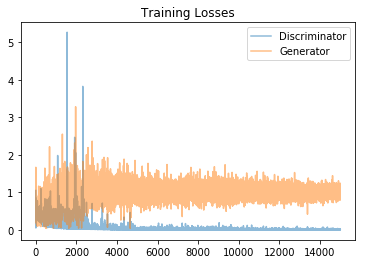

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

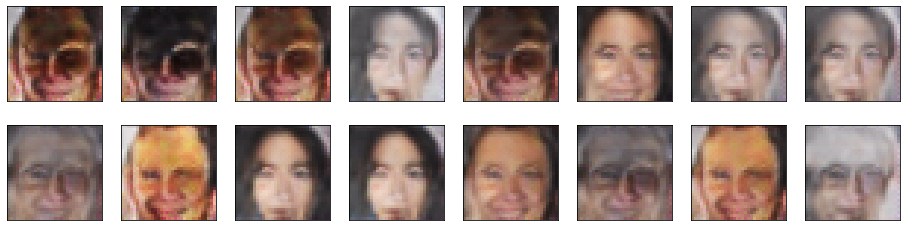

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

- Interesting to see the amount of noise, and odd patterns that can get past the discriminator
- There are a collection of a few features which seem to be re-used, many of the faces are very similar (should add more convolutional layers so the model would be better placed to handle more complex/wider variety of features)
- Would be interesting to experiment with creating larger/higher resolution imagery (but don't have the time ☹️)
- I initially ran this for 50 epochs, then out of curiousity I cranked up the epochs to 1000 and ran overnight to see how the loss would vary. The results from 50 epochs was actually much more realistic. Over 1000 epochs the generator seems to have overfit/honed in on a select few features that must have been successful in fooling the discriminator?

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.